## Pipeline Script 
This script 

### Import Packages

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import network_fcon as fc
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re

### Define paths and variables

In [9]:
# Set paths
inpath = "/Users/pecsok/Desktop/ImageData/PMACS_remote/data/fmri/postprocessed/3T/xcp_d"
outpath = "~/Desktop/ImageData/PMACS_remote/analysis/postprocessing/"
clinpath = "~/Desktop/ImageData/PMACS_remote/data/clinical"
cestpath = "/Users/pecsok/Desktop/ImageData/PMACS_remote/data/cest/output_measures/UNI/"

# Choose what to analyse
networks = ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"] 
CESTnetworks = ["avgCEST_Cont", "ctCEST_Cont", "avgCEST_Default", "ctCEST_Default","avgCEST_SomMot", "ctCEST_SomMot", "avgCEST_DorsAttn", "ctCEST_DorsAttn", "avgCEST_Vis", "ctCEST_Vis","avgCEST_Limbic", "ctCEST_Limbic",  "avgCEST_SalVentAttn","ctCEST_SalVentAttn"]
CNB_scores = ["tap_tot", "er40_cr", "medf_pc"] #, 
CNB_valids = ["tap_valid", "er40_valid", "medf_valid"] #, 
diag_scores = ["dx_pscat"] # ,"axis1_desc1","axis1_stat1"
demo_scores = ["sex", "age", "race","ethnic","dateDiff"]
diag_details = ["axis1_desc1", "axis1_desc2", "axis1_desc3","axis1_desc4","axis1_desc5", "axis1_desc6"]

# Make dataframe based on metrics of interest
#columns = ["BBLID"] + ["Session"] + networks
#fcon_df = pd.DataFrame(columns=columns)
#clin_df = pd.DataFrame(columns=["BBLID", "Session"] + CNB_scores + clinical_scores + diag_scores)
grp_df = pd.DataFrame(columns = ["BBLID"] + ["Session"] + demo_scores + networks + CESTnetworks + CNB_scores + diag_scores)
diag_df = pd.DataFrame(columns = ["BBLID"] + ["Session"] + diag_scores + diag_details)
print(grp_df)

# Initialize empty lists and vars
bblids = []
sesids = []
both3T_7T = []

# Import group dataframes and set indices
subjlist = pd.read_csv("~/Desktop/ImageData/PMACS_remote/data/pipeline_input_all_subj.csv", sep=',') 
cnbmat = pd.read_csv(clinpath + "/maggie_datarequest_fullcnb_copy.csv", sep=',') 
diagmat = pd.read_csv(clinpath + "/020424_maggie_datarequest_cnb_updated.csv", sep=',')
demomat = pd.read_csv(clinpath + "/demographics.csv", sep=',')
# cestmat = pd.read_csv(clinpath + "/demographics.csv", sep='\t') add grp CEST map here

# Reformat some dfs
cnbmat.set_index('bblid', inplace = True)
diagmat.set_index('bblid', inplace = True)
demomat.set_index('bblid', inplace = True)
subjlist = subjlist.dropna(how='all')
subjlist.rename(columns={'fMRI Field Strength': 'fieldstrength'},inplace=True)
# FIXXXXX Correct subject list for future! 
subjlist.loc[subjlist['BBLID'] == 88608.0, 'SCANID_rs'] = 'motive2'
subjlist.loc[subjlist['BBLID'] == 20792.0, 'SCANID_rs'] = 'motive2'
subjlist.loc[subjlist['BBLID'] == 88760.0, 'SCANID_rs'] = 'motive2'
subjlist.loc[subjlist['BBLID'] == 112126.0, 'SCANID_rs'] = 'motive1'
subjlist.loc[subjlist['BBLID'] == 91962.0, 'SCANID_rs'] = 'motive1'
subjlist.loc[subjlist['BBLID'] == 89279.0, 'SCANID_rs'] = 'motive1'
subjlist.loc[subjlist['BBLID'] == 91422.0, 'SCANID_rs'] = 'motive1'
subjlist.loc[subjlist['BBLID'] == 121407.0, 'SCANID_rs'] = '9257'
print(subjlist)  
              
print("yes")
#### Troubleshooting: Initialize empty matrix for fcmats # FIX if desired:
#num_matrices = 100  # You can change this to the desired number
#matrix_shape = (700, 701)
#index = pd.MultiIndex.from_product([range(num_matrices), range(matrix_shape[0]), range(matrix_shape[1])], names=['Matrix', 'Row', 'Column'])
#fcmats = pd.DataFrame(data, index=index, columns=['Value'])

print(subjlist.loc[subjlist['BBLID'] == 20792.0, 'SCANID_rs'])


Empty DataFrame
Columns: [BBLID, Session, sex, age, race, ethnic, dateDiff, Cont, Default, DorsAttn, Vis, SalVentAttn, SomMot, Limbic, avgCEST_Cont, ctCEST_Cont, avgCEST_Default, ctCEST_Default, avgCEST_SomMot, ctCEST_SomMot, avgCEST_DorsAttn, ctCEST_DorsAttn, avgCEST_Vis, ctCEST_Vis, avgCEST_Limbic, ctCEST_Limbic, avgCEST_SalVentAttn, ctCEST_SalVentAttn, tap_tot, er40_cr, medf_pc, dx_pscat]
Index: []

[0 rows x 32 columns]
      BBLID                  PROTOCOL_CEST DOSCAN_CEST  SCANID_CEST  lagtime  \
0     20303           843329 - LongGluCEST      6/2/22        12234      -85   
1     90217           843329 - LongGluCEST     5/19/22        12230       90   
2     88608           843329 - LongGluCEST     3/22/22        12108       55   
3     21874           843329 - LongGluCEST      3/8/22        12094       42   
4     94288           843329 - LongGluCEST      3/4/22        12092      126   
..      ...                            ...         ...          ...      ...   
119   90877 

### Choose which modules to run

In [7]:
fieldstrength = '3T'
runfcon = True
runCNB = True
rundiag = True
rundemo = True
runcest = True
run_grpanalysis = True

## Stage 1: Create Group Data Frame
### Import data, loop through subjects, and establish file paths


FIX THIS ERROR:
/var/folders/ls/hy_z7hgd4_13km3h7j84vqh40000gp/T/ipykernel_77945/3898733492.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'PSY' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  grp_df.loc[grp_df['BBLID'].astype(str) == bblid, grp_df.columns == diag_score] = diagnosis

In [8]:
# First, make df to keep track of who has 3T and 7T fMRI scan.
subjs = subjlist['BBLID']
for subj in subjs:
    bblid = str(int(subj))
    ses=subjlist.loc[subjlist['BBLID'] == float(bblid), 'SCANID_rs'].values
    if len(ses) >1: # & fieldstrength = '7T':
        both3T_7T.append(bblid)
both3T_7T = pd.DataFrame(both3T_7T)
both3T_7T.to_csv('both3T_7T.csv', index=True)

# Generates list of all file names
folder_names = [folder for folder in glob.glob(os.path.join(inpath, "*")) if os.path.isdir(folder)]
# Loop through subjects


# OLD CHUNK
for subj_path in folder_names:
    if "sub" in subj_path:
        # Extract bblid id:
        # print(subj_path)
        bblid = subj_path.split('-')[1]
        print("Processing subject " + bblid)
        # Extract session id: 
        items = os.listdir(subj_path)
        ses_folder = [item for item in items if item.startswith("ses")]
        ses = ses_folder[0].split('-')[1]
        ses_path = os.path.join(inpath, subj_path, ses_folder[0]) # full path to session
        # Add to running list of IDs grp analysis later:
        bblids.append(bblid)
        sesids.append(ses)
        # Start new row in grp_df for this subject:
        ids = [bblid, ses]  # Values for the first two columns
        grp_df.loc[len(grp_df)] = ids + [float('nan')] * (len(grp_df.columns) - len(ids))
        diag_df.loc[len(diag_df)] = ids + [float('nan')] * (len(diag_df.columns) - len(ids))

# OLD CHUNK 
subjlist = subjlist[subjlist['fieldstrength']=='3T']
subjs = subjlist['BBLID']
for subj in subjs:
    bblid = str(int(subj))
    ses=subjlist.loc[subjlist['BBLID'] == float(bblid), 'SCANID_rs'].values #CEST  fcmat.columns[fcmat.columns.str.contains(network)]]
#    ses=ses[0] # Change for 3T vs 7T!!!!
    ses_path = os.path.join(inpath, "sub-" + bblid, "ses-" + ses[0])
    ids = [bblid, ses]  # Values for the first two columns
    grp_df.loc[len(grp_df)] = ids + [float('nan')] * (len(grp_df.columns) - len(ids))
    diag_df.loc[len(diag_df)] = ids + [float('nan')] * (len(diag_df.columns) - len(ids))
 #   print(ids)
    # Run a subset of subjs or exclude specific subjs.
    if bblid != "102041" and bblid != "20082": #bblid != "20902" and bblid != "93242"  and bblid != "20754" and bblid != "127065" and 
        ##################################################################################################
        ## FC
        ##################################################################################################
        if runfcon:
        #    print("yes")
            fcmat_glob = f"{ses_path}/func/*Schaefer117_measure-pearsoncorrelation_conmat.tsv"
        #    print(fcmat_glob)
            if glob.glob(fcmat_glob) and os.path.isfile(glob.glob(fcmat_glob)[0]): # FIX this is giving error when file doesn't e
                fcmat = pd.read_csv(glob.glob(fcmat_glob)[0], sep='\t') 
                fcmat.set_index('Node', inplace = True)
                # Loop through the networks
                print("Running fcon")
                for network in networks:
                    # Select rows and columns corresponding to the network
                    network_fc = fcmat.loc[fcmat.index.str.contains(network), fcmat.columns[fcmat.columns.str.contains(network)]]
                    #print(network_fc)
                    # Calculate avg network fc and add value to proper column in grp_df
                    grp_df.loc[len(grp_df)-1, network] = network_fc.values.mean()



Processing subject 117847
Processing subject 20645
Processing subject 128865
Processing subject 120217
Processing subject 21118
Processing subject 125511
Processing subject 105176
Processing subject 132179
Processing subject 15305
Processing subject 17621
Processing subject 98831
Processing subject 20916
Processing subject 116019
Processing subject 17648
Processing subject 96902
Processing subject 118864
Processing subject 20325
Processing subject 80557
Processing subject 20642
Processing subject 94378
Processing subject 94028
Processing subject 125073
Processing subject 121085
Processing subject 135085
Processing subject 85369
Processing subject 93292
Processing subject 100522
Processing subject 116354
Processing subject 114738
Processing subject 90281
Processing subject 96659
Processing subject 87646
Processing subject 135277
Processing subject 117397
Processing subject 93274
Processing subject 20902
Processing subject 128259
Processing subject 93242
Processing subject 106880
Process

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [12]:
# loop through subjs and create grp_df
# .values[0].astype(str) 
subjlist = subjlist[subjlist['fieldstrength']== fieldstrength]
subjs = subjlist['BBLID']
for subj in subjs:
    bblid = str(int(subj))
    ses=subjlist.loc[subjlist['BBLID'] == float(bblid), 'SCANID_rs'].values  #FIX array --> string format  fcmat.columns[fcmat.columns.str.contains(network)]]
    ses_path = os.path.join(inpath, "sub-" + bblid, "ses-" + ses[0])
    ids = [bblid, ses]  # Values for the first two columns
    grp_df.loc[len(grp_df)] = ids + [float('nan')] * (len(grp_df.columns) - len(ids))
    diag_df.loc[len(diag_df)] = ids + [float('nan')] * (len(diag_df.columns) - len(ids))
    
    # Run a subset of subjs or exclude specific subjs.
    if bblid != "102041" and bblid != "20082" and bblid != "88760" and bblid != "20916" and bblid != "22473" and bblid != "132869": 
        ##################################################################################################
        ## CEST
        ##################################################################################################
        if runcest: #88760's CEST output is empty for some reason.
            print("Processing " + bblid + "'s CEST data'")
            # Extract Glu session ID
            gluses = subjlist.loc[subjlist['BBLID'] == float(bblid), 'SCANID_CEST'].values[0].astype(str) #.
            cestid = bblid + "_" + gluses
            # Import data
            for network in networks:
                cest_pattern = cestpath + cestid + "/" + cestid + "-2d-GluCEST-s100_7-" + network + "-measures_UNI.tsv"
                cestfile = glob.glob(cest_pattern)
                for file in cestfile:
                    if cestfile and os.path.isfile(file):
                        cestmat = pd.read_csv(file, sep='\t') 
                        means = [] 
                        counts = []
                        col_name = "avgCEST_" + network # for grp_df
                        ct_name = "ctCEST_" + network # for grp_df
                        for index, value in enumerate(cestmat.loc[0,:]):
                             if "Mean" in cestmat.columns[index] and not np.isnan(value):
                                # cestmat.at[0, cestmat.columns[index]] = float(value) * float(cestmat.iloc[0, index + 1])
                                means.append(cestmat.at[0, cestmat.columns[index]])
                                counts.append(cestmat.at[0, cestmat.columns[index + 1]])
                        if sum(counts) == 0:
                            grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == col_name] = "NaN"
                            grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == col_name] = "NaN"
                        else:
                            grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == col_name] = sum(means) # / sum(counts)
                            grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == ct_name] = sum(counts) # / sum(counts)

        ##################################################################################################
        ## FC
        ##################################################################################################
        if runfcon:
            fcmat_glob = f"{ses_path}/func/*Schaefer117_measure-pearsoncorrelation_conmat.tsv"
            if glob.glob(fcmat_glob) and os.path.isfile(glob.glob(fcmat_glob)[0]): # FIX this is giving error when file doesn't e
                fcmat = pd.read_csv(glob.glob(fcmat_glob)[0], sep='\t') 
                fcmat.set_index('Node', inplace = True)
                # Loop through the networks
                print("Running fcon")
                for network in networks:
                    # Select rows and columns corresponding to the network
                    network_fc = fcmat.loc[fcmat.index.str.contains(network), fcmat.columns[fcmat.columns.str.contains(network)]]
                    #print(network_fc)
                    # Calculate avg network fc and add value to proper column in grp_df
                    grp_df.loc[len(grp_df)-1, network] = network_fc.values.mean()
            ##################################################################################################
            ## CNB
            ##################################################################################################
            if runCNB:
                # Loop through the CNB scores
                for i in range(len(CNB_scores)):
                    CNB_score = CNB_scores[i]
                    CNB_valid = CNB_valids[i]
                    # Select score of interest & validity of that score
                    scores = cnbmat[CNB_score]
                    if int(bblid) in scores.index:
                        score = scores[int(bblid)]
                        valids = cnbmat[CNB_valid]
                        valid = str(valids[int(bblid)])
                        # If score was valid, add to grp_df
                        if 'V' in valid:
                            grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == CNB_score] = score 
            ##################################################################################################
            ## Diagnosis
            ##################################################################################################
            if rundiag:
                # Loop through the CNB scores
                for i in range(len(diag_scores)):
                    diag_score = diag_scores[i]
                    # Select score of interest and add to grp_df
                    diagnoses = diagmat[diag_score]
                    if int(bblid) in diagnoses.index:
                        diagnosis = diagnoses[int(bblid)]
                        grp_df.loc[grp_df['BBLID'].astype(str) == bblid, grp_df.columns == diag_score] = diagnosis 
                        diag_df.loc[diag_df['BBLID'].astype(str) == bblid, diag_df.columns == diag_score] = diagnosis 
                    else:
                        diagnosis = "Unknown"
                        grp_df.loc[grp_df['BBLID'].astype(str) == bblid, grp_df.columns == diag_score] = diagnosis 
                        diag_df.loc[diag_df['BBLID'].astype(str) == bblid, diag_df.columns == diag_score] = diagnosis
                
                # Loop through diag scores
                for i in range(len(diag_details)):
                    diag_detail = diag_details[i]
                    # Select score of interest and add to grp_df
                    comorbidities = diagmat[diag_detail]
                    if int(bblid) in comorbidities.index:
                        comorbidity = comorbidities[int(bblid)]
                       # print(comorbidity)
                        diag_df.loc[diag_df['BBLID'].astype(str) == bblid, diag_df.columns == diag_detail] = comorbidity 
                    else:
                        comorbidity = "Unknown"
                        diag_df.loc[diag_df['BBLID'].astype(str) == bblid, diag_df.columns == diag_detail] = comorbidity
                        
            ##################################################################################################
            ## Demographics
            ##################################################################################################
            if rundemo:
                # Loop through the CNB scores
                for i in range(len(demo_scores)):
                    demo_score = demo_scores[i]
                    # Select metric of interest
                    scores = demomat[demo_score]
                    if int(bblid) in scores.index:
                        score = scores[int(bblid)]
                        # Add to grp_df
                        grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == demo_score] = score 

print(grp_df)

Processing 20303's CEST data'
Running fcon
Processing 90217's CEST data'
Running fcon
Processing 88608's CEST data'
Running fcon
Processing 21874's CEST data'
Running fcon
Processing 94288's CEST data'
Running fcon
Processing 94703's CEST data'
Running fcon
Processing 93757's CEST data'
Running fcon
Processing 96902's CEST data'
Running fcon
Processing 20792's CEST data'
Running fcon
Processing 20325's CEST data'
Running fcon
Processing 125073's CEST data'
Running fcon
Processing 115783's CEST data'
Running fcon
Processing 118864's CEST data'
Running fcon
Processing 116354's CEST data'
Running fcon
Processing 111720's CEST data'
Running fcon
Processing 91422's CEST data'
Running fcon
Processing 20642's CEST data'
Running fcon
Processing 20645's CEST data'
Running fcon
Processing 20543's CEST data'
Running fcon
Processing 112126's CEST data'
Running fcon
Processing 116019's CEST data'
Running fcon
Processing 106057's CEST data'
Running fcon
Processing 89095's CEST data'
Running fcon
Pro

## Stage 2: Group Comparisons and Regressions

In [13]:
grp_df.to_csv('grp_df_3T.csv', index=True)
diag_df.to_csv('diag_df_3T.csv', index=True)

### Network FCON 
Call fcon function and calculate network-level connectivity measures for subject and add  subject data to group file for future group analysis

### Demographics table

avgCEST_Default


TypeError: jointplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

In [314]:
!jupyter nbconvert --to html pipeline.ipynb --output pipeline_3T.html

[NbConvertApp] Converting notebook pipeline.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 63 image(s).
[NbConvertApp] Writing 3071514 bytes to pipeline_3T.html


hstatus
HC       10
Other    10
PSY       9
Name: count, dtype: int64
hstatus
HC       10
Other    10
PSY       9
Name: count, dtype: int64
     BBLID Session  sex    age  race  ethnic  dateDiff      Cont   Default  \
0    19830   10789  2.0  21.92   1.0     2.0       0.0  0.175604  0.376170   
1    20645   11260  1.0  19.84   2.0     2.0       0.0       NaN  0.210973   
2   125511   10906  2.0  20.86   1.0     2.0       0.0       NaN  0.260692   
3   116019   11135  2.0  25.72   2.0     1.0       0.0  0.121458  0.322248   
4    19790   10819  2.0  23.37   1.0     2.0       0.0  0.248519  0.331945   
5    80557   10738  2.0  29.28   2.0     2.0       0.0       NaN       NaN   
6    20642   11261  1.0  25.59   NaN     NaN       0.0  0.232299  0.216163   
7    20180   11011  1.0  15.43   1.0     2.0      15.0  0.096672  0.101490   
8   139272   10739  NaN    NaN   NaN     NaN       NaN  0.085998  0.153989   
9   121085   10851  2.0  20.84   1.0     2.0      14.0  0.201904  0.159492   
10

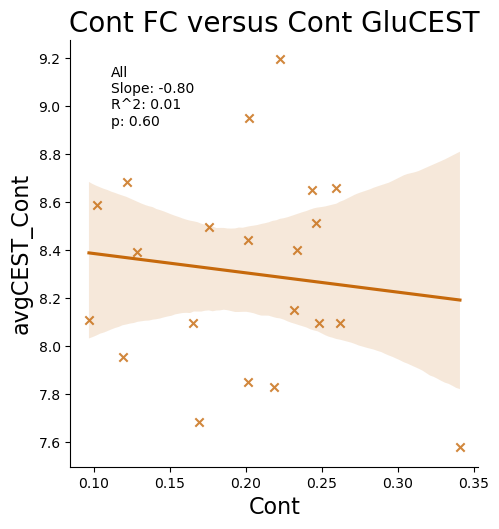

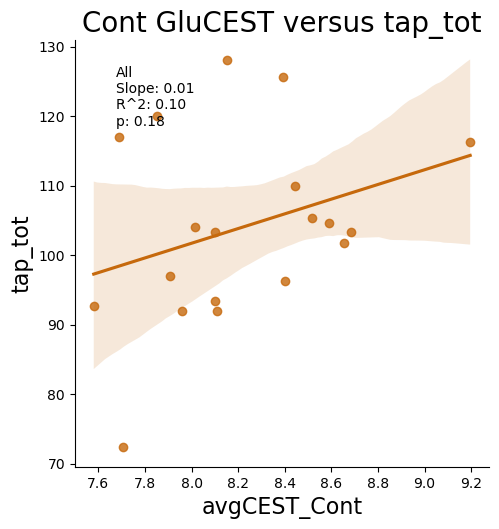

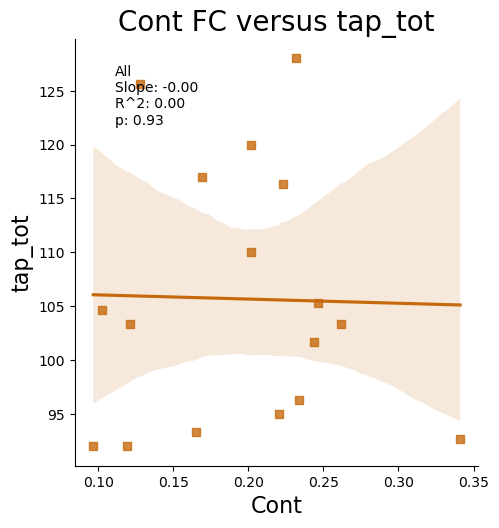

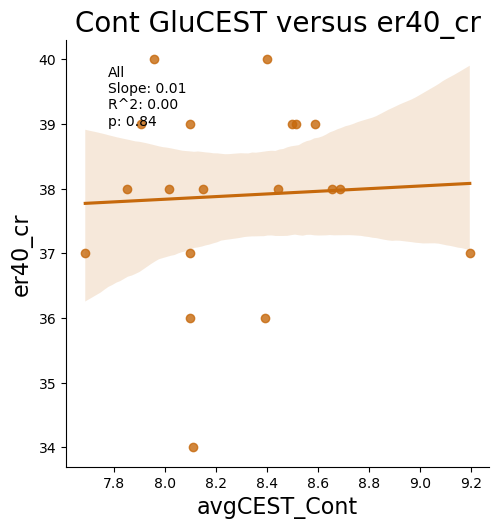

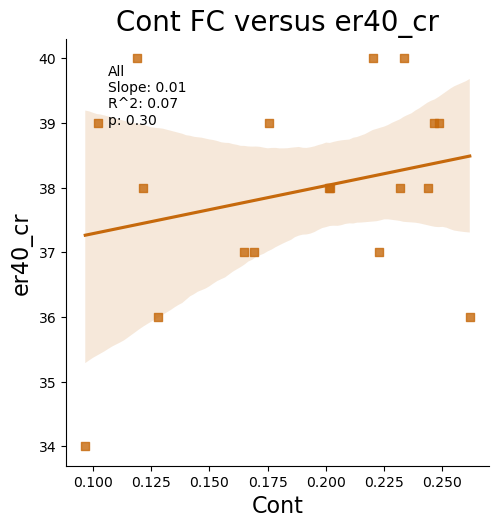

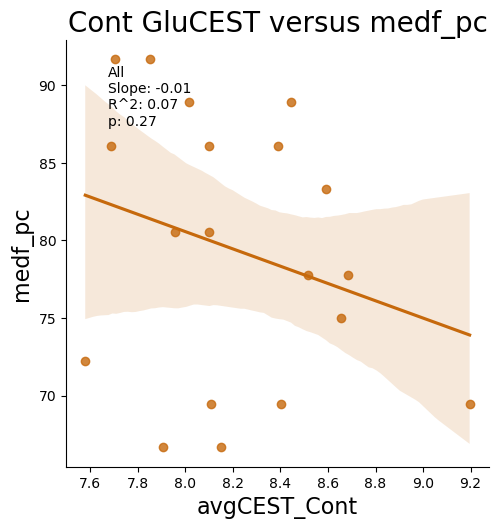

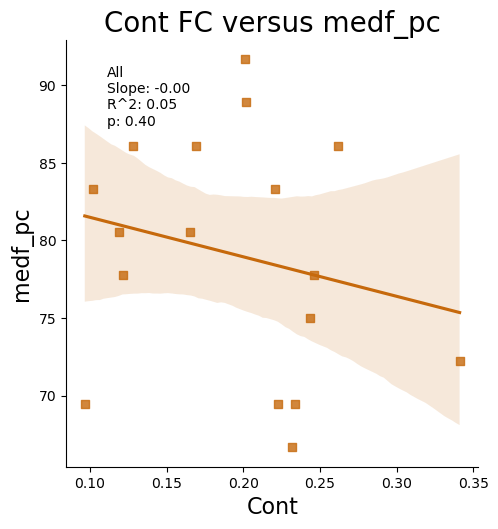

  hstatus_  avgCEST_Cont_mean  avgCEST_Cont_std  Cont_mean  Cont_std
0       HC           8.185614          0.499726   0.214508  0.071204
1    Other           8.067074          0.188945   0.142057  0.058799
2      PSY           8.444832          0.392330   0.209340  0.043280


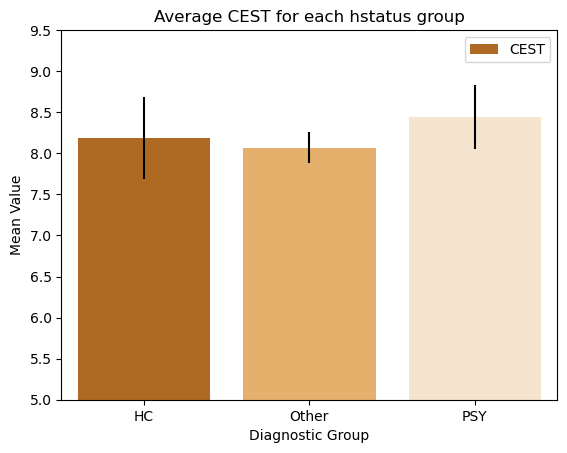

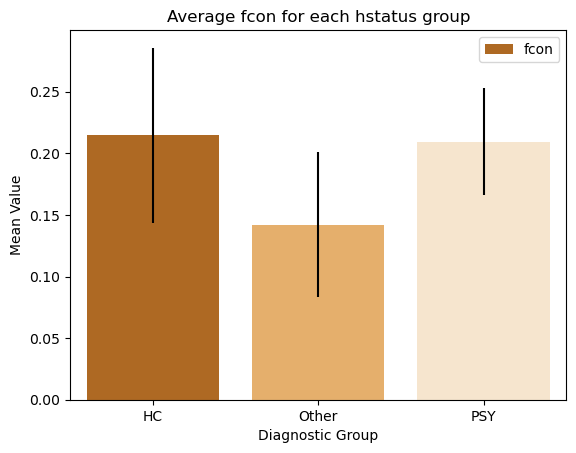

     BBLID Session  sex    age  race  ethnic  dateDiff      Cont   Default  \
0    19830   10789  2.0  21.92   1.0     2.0       0.0  0.175604  0.376170   
1    20645   11260  1.0  19.84   2.0     2.0       0.0       NaN  0.210973   
2   125511   10906  2.0  20.86   1.0     2.0       0.0       NaN  0.260692   
3   116019   11135  2.0  25.72   2.0     1.0       0.0  0.121458  0.322248   
4    19790   10819  2.0  23.37   1.0     2.0       0.0  0.248519  0.331945   
5    80557   10738  2.0  29.28   2.0     2.0       0.0       NaN       NaN   
6    20642   11261  1.0  25.59   NaN     NaN       0.0  0.232299  0.216163   
7    20180   11011  1.0  15.43   1.0     2.0      15.0  0.096672  0.101490   
8   139272   10739  NaN    NaN   NaN     NaN       NaN  0.085998  0.153989   
9   121085   10851  2.0  20.84   1.0     2.0      14.0  0.201904  0.159492   
10   93292   10938  2.0  25.32   2.0     2.0       0.0  0.246400  0.168437   
11   90281   10902  2.0  22.89   1.0     2.0      52.0       NaN

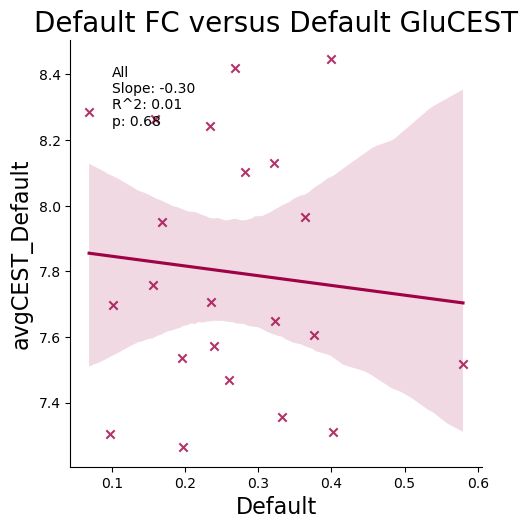

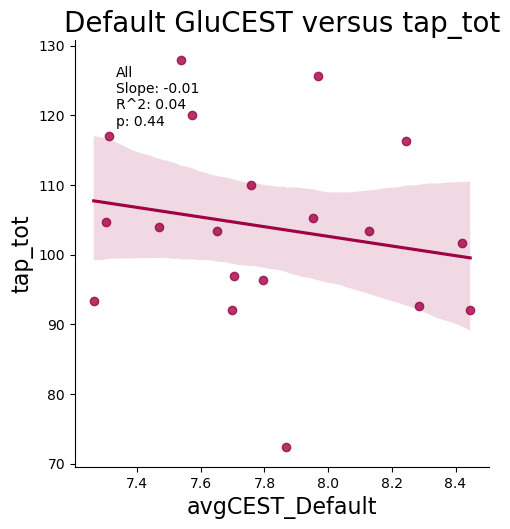

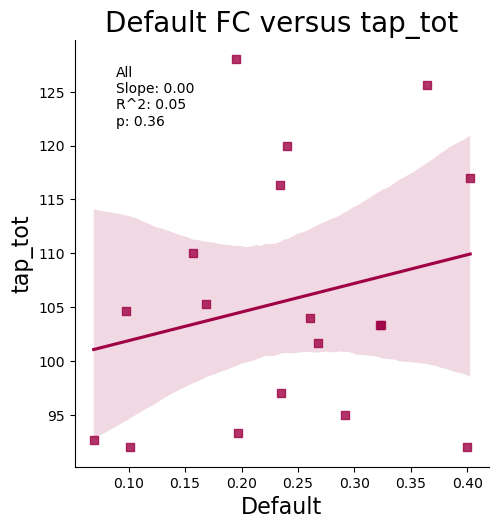

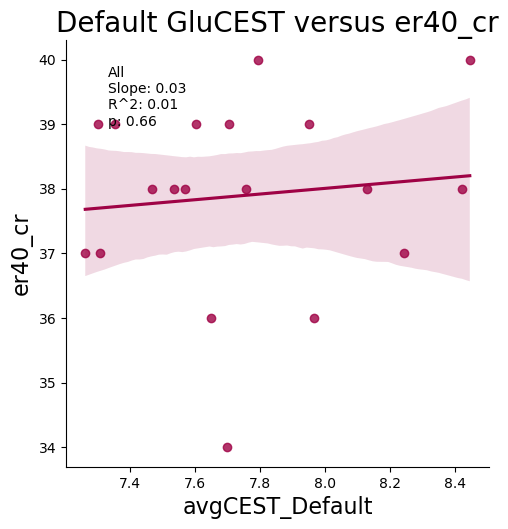

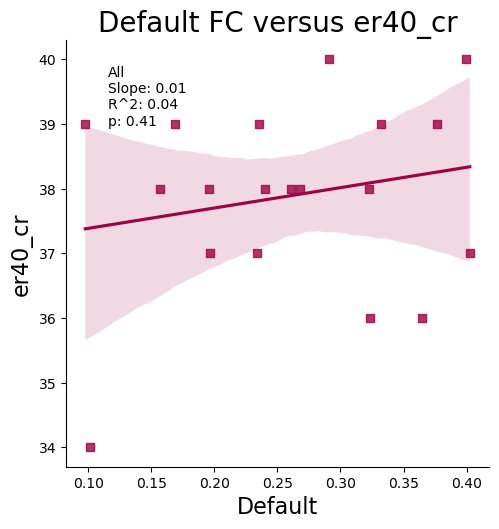

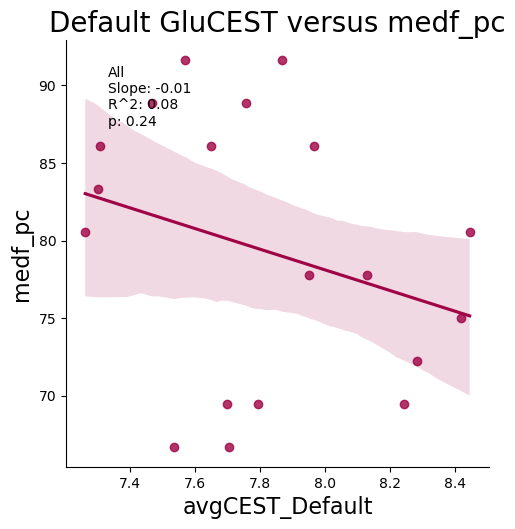

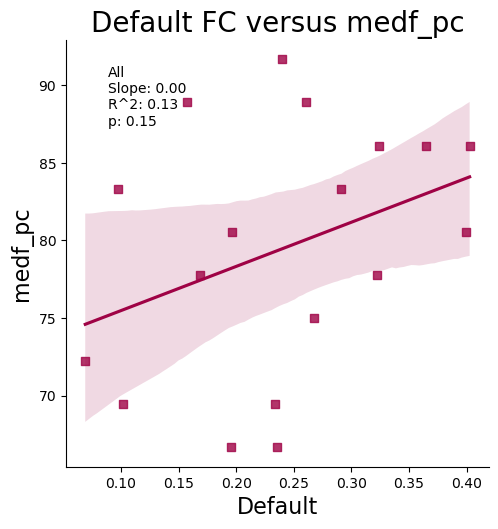

  hstatus_  avgCEST_Default_mean  avgCEST_Default_std  Default_mean  \
0       HC              7.823633             0.416928      0.246967   
1    Other              7.742404             0.405308      0.292824   
2      PSY              7.817142             0.321882      0.224426   

   Default_std  
0     0.117733  
1     0.135403  
2     0.056645  


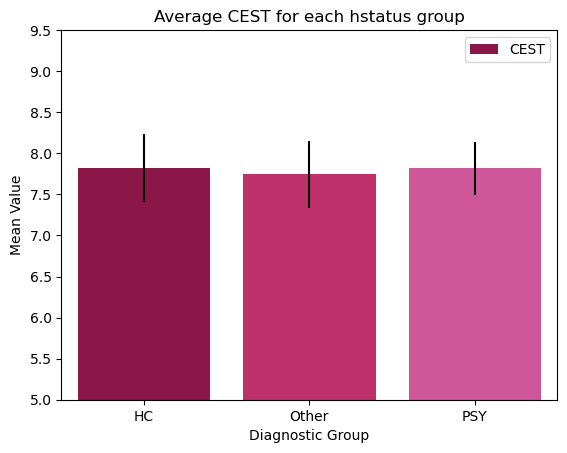

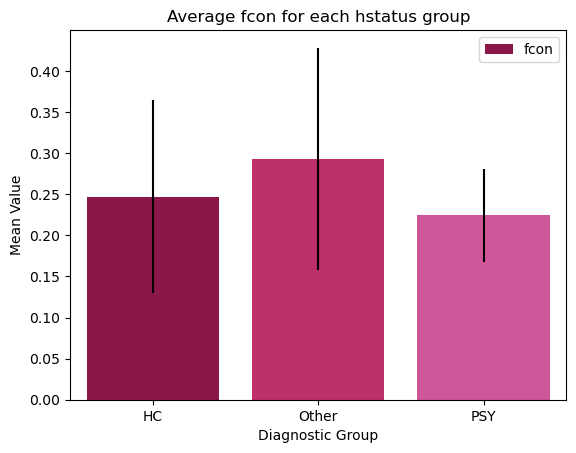

     BBLID Session  sex    age  race  ethnic  dateDiff      Cont   Default  \
0    19830   10789  2.0  21.92   1.0     2.0       0.0  0.175604  0.376170   
1    20645   11260  1.0  19.84   2.0     2.0       0.0       NaN  0.210973   
2   125511   10906  2.0  20.86   1.0     2.0       0.0       NaN  0.260692   
3   116019   11135  2.0  25.72   2.0     1.0       0.0  0.121458  0.322248   
4    19790   10819  2.0  23.37   1.0     2.0       0.0  0.248519  0.331945   
5    80557   10738  2.0  29.28   2.0     2.0       0.0       NaN       NaN   
6    20642   11261  1.0  25.59   NaN     NaN       0.0  0.232299  0.216163   
7    20180   11011  1.0  15.43   1.0     2.0      15.0  0.096672  0.101490   
8   139272   10739  NaN    NaN   NaN     NaN       NaN  0.085998  0.153989   
9   121085   10851  2.0  20.84   1.0     2.0      14.0  0.201904  0.159492   
10   93292   10938  2.0  25.32   2.0     2.0       0.0  0.246400  0.168437   
11   90281   10902  2.0  22.89   1.0     2.0      52.0       NaN

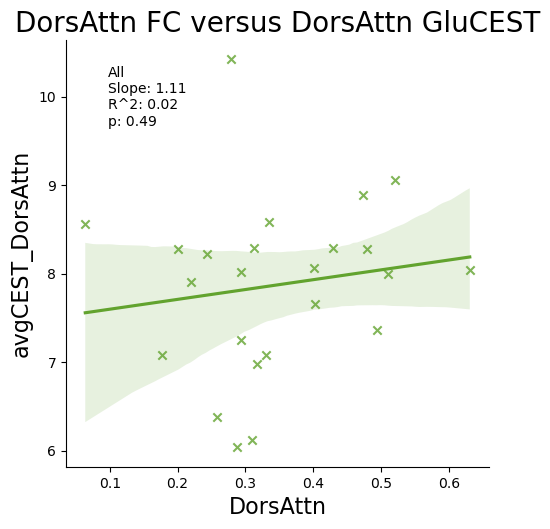

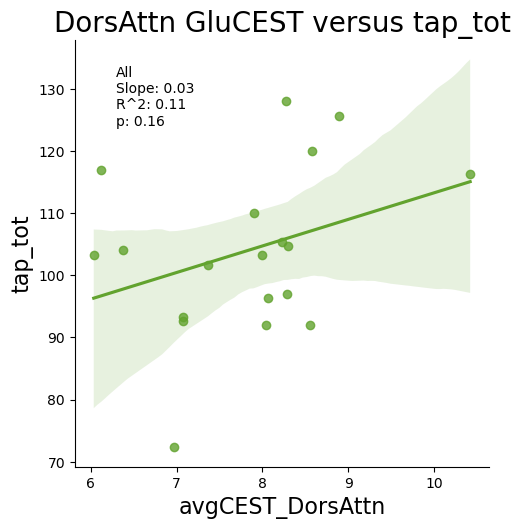

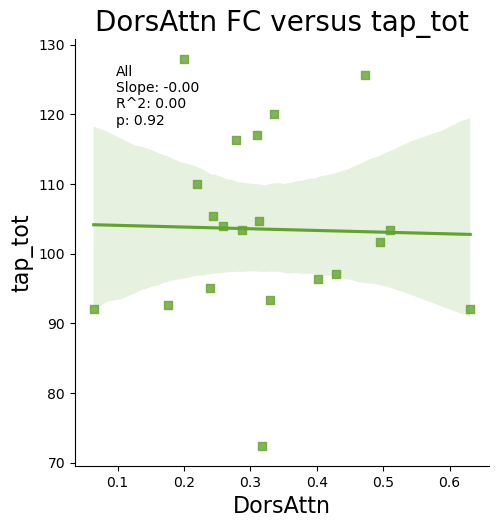

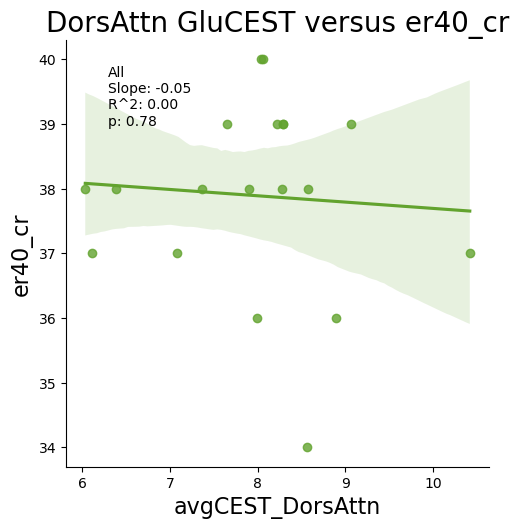

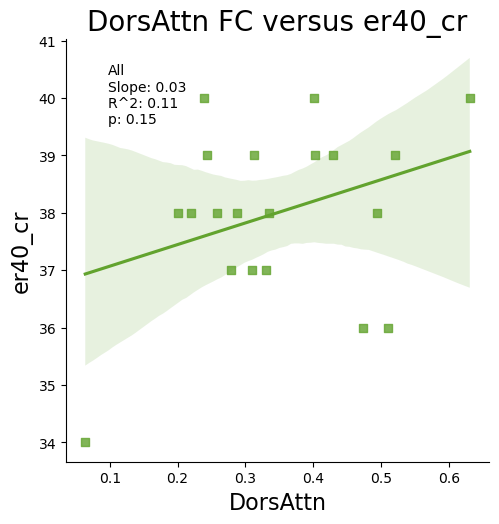

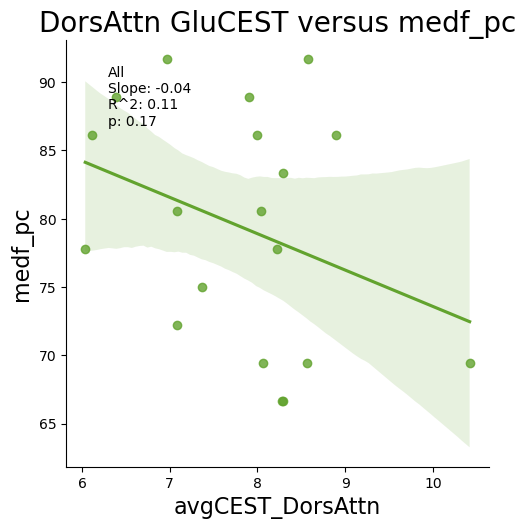

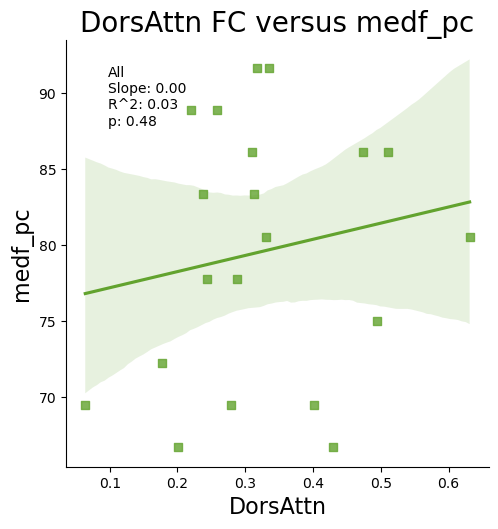

  hstatus_  avgCEST_DorsAttn_mean  avgCEST_DorsAttn_std  DorsAttn_mean  \
0       HC               7.531305              0.721082       0.348481   
1    Other               8.203656              0.968130       0.351299   
2      PSY               7.981276              1.204224       0.287799   

   DorsAttn_std  
0      0.108400  
1      0.169187  
2      0.062560  


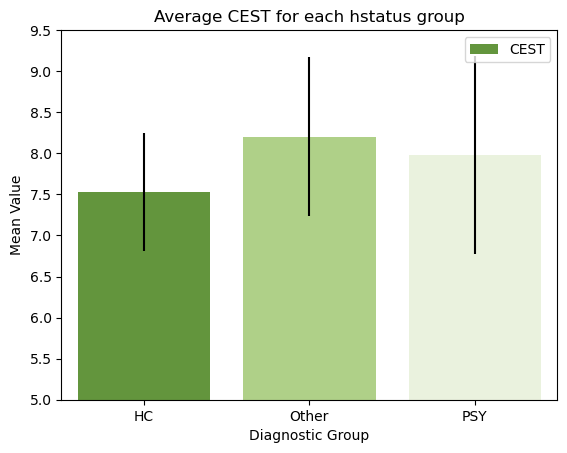

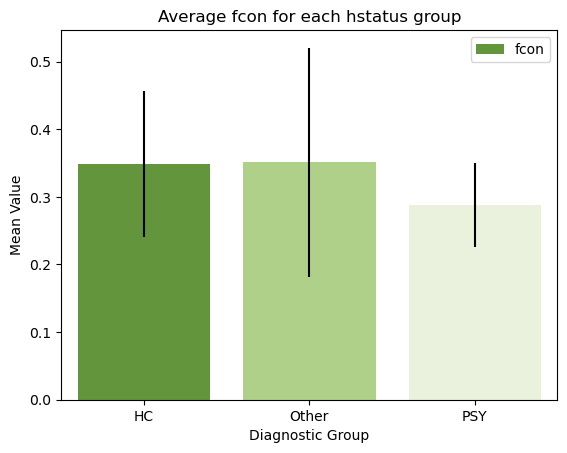

     BBLID Session  sex    age  race  ethnic  dateDiff      Cont   Default  \
0    19830   10789  2.0  21.92   1.0     2.0       0.0  0.175604  0.376170   
1    20645   11260  1.0  19.84   2.0     2.0       0.0       NaN  0.210973   
2   125511   10906  2.0  20.86   1.0     2.0       0.0       NaN  0.260692   
3   116019   11135  2.0  25.72   2.0     1.0       0.0  0.121458  0.322248   
4    19790   10819  2.0  23.37   1.0     2.0       0.0  0.248519  0.331945   
5    80557   10738  2.0  29.28   2.0     2.0       0.0       NaN       NaN   
6    20642   11261  1.0  25.59   NaN     NaN       0.0  0.232299  0.216163   
7    20180   11011  1.0  15.43   1.0     2.0      15.0  0.096672  0.101490   
8   139272   10739  NaN    NaN   NaN     NaN       NaN  0.085998  0.153989   
9   121085   10851  2.0  20.84   1.0     2.0      14.0  0.201904  0.159492   
10   93292   10938  2.0  25.32   2.0     2.0       0.0  0.246400  0.168437   
11   90281   10902  2.0  22.89   1.0     2.0      52.0       NaN

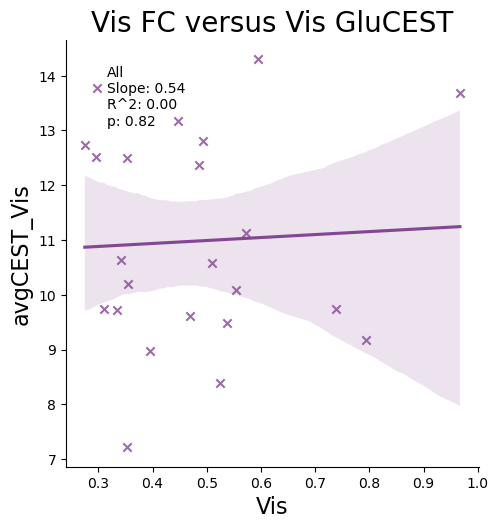

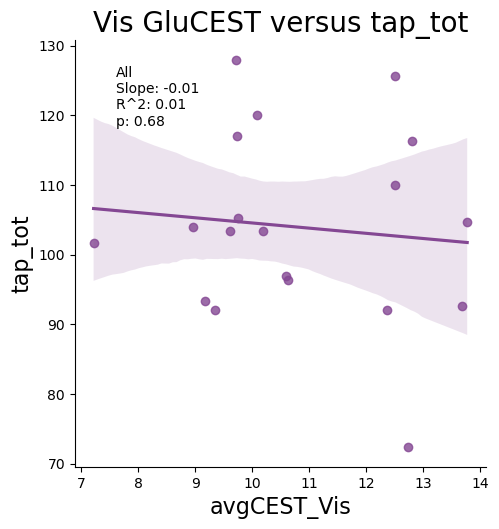

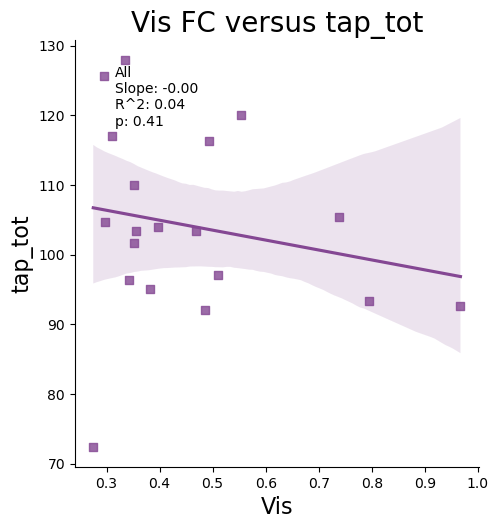

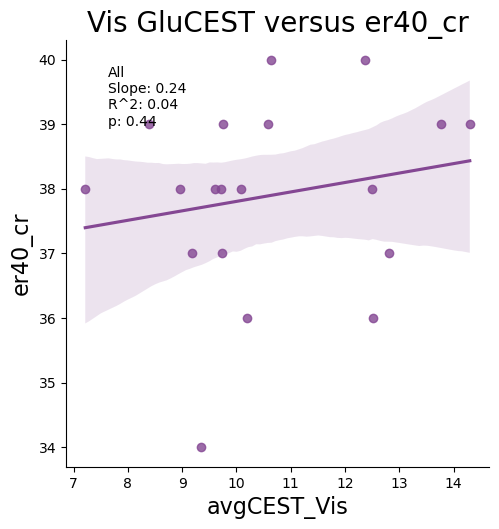

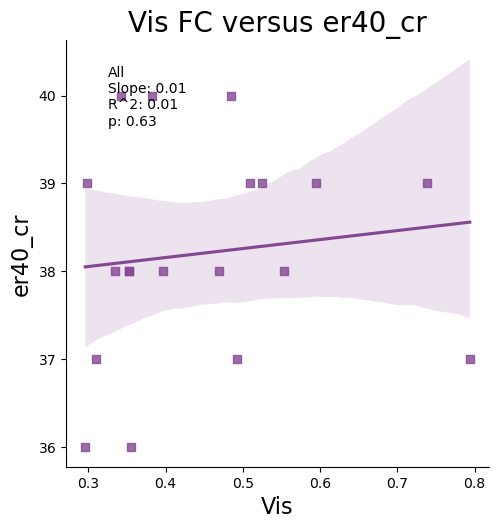

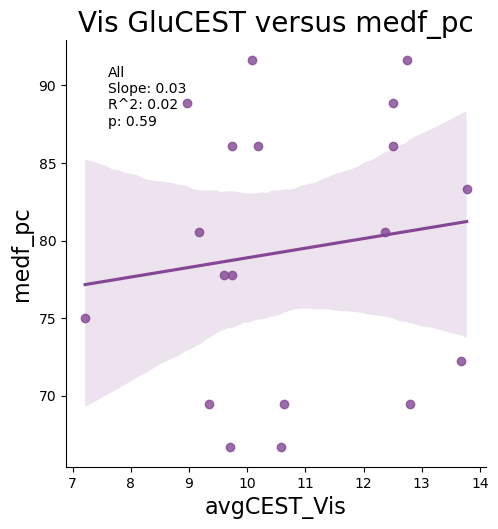

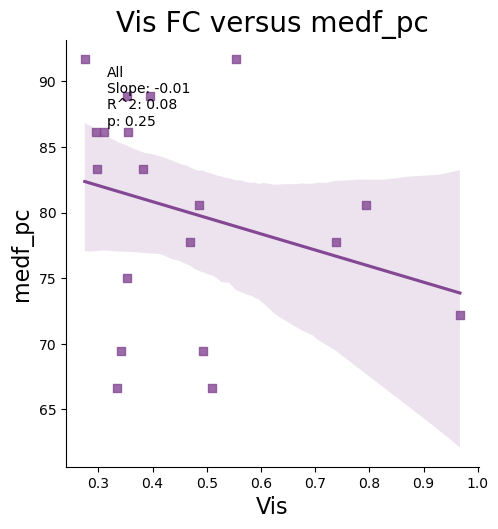

  hstatus_  avgCEST_Vis_mean  avgCEST_Vis_std  Vis_mean   Vis_std
0       HC         11.711762         2.390401  0.448846  0.207738
1    Other         10.177118         1.795586  0.565973  0.185518
2      PSY         10.600301         1.300093  0.516471  0.167178


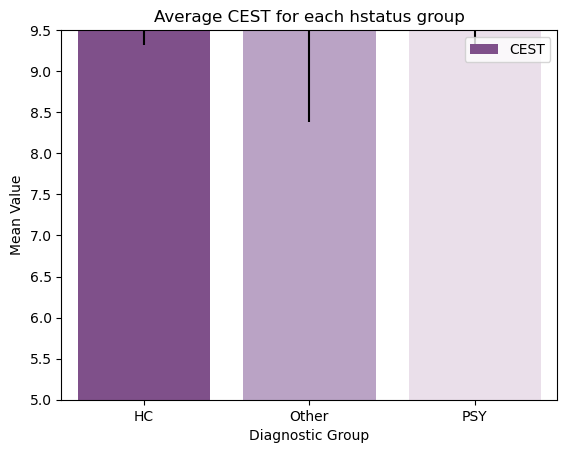

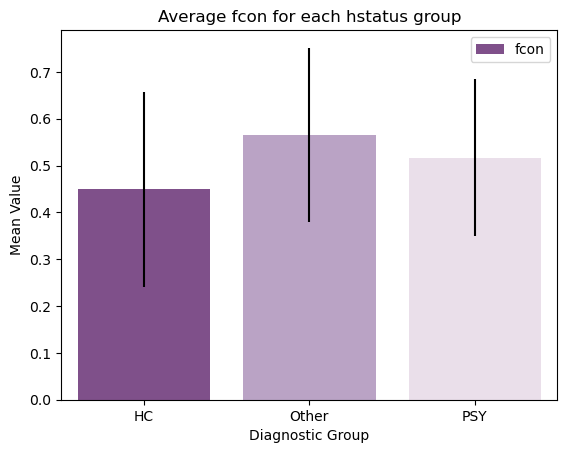

     BBLID Session  sex    age  race  ethnic  dateDiff      Cont   Default  \
0    19830   10789  2.0  21.92   1.0     2.0       0.0  0.175604  0.376170   
1    20645   11260  1.0  19.84   2.0     2.0       0.0       NaN  0.210973   
2   125511   10906  2.0  20.86   1.0     2.0       0.0       NaN  0.260692   
3   116019   11135  2.0  25.72   2.0     1.0       0.0  0.121458  0.322248   
4    19790   10819  2.0  23.37   1.0     2.0       0.0  0.248519  0.331945   
5    80557   10738  2.0  29.28   2.0     2.0       0.0       NaN       NaN   
6    20642   11261  1.0  25.59   NaN     NaN       0.0  0.232299  0.216163   
7    20180   11011  1.0  15.43   1.0     2.0      15.0  0.096672  0.101490   
8   139272   10739  NaN    NaN   NaN     NaN       NaN  0.085998  0.153989   
9   121085   10851  2.0  20.84   1.0     2.0      14.0  0.201904  0.159492   
10   93292   10938  2.0  25.32   2.0     2.0       0.0  0.246400  0.168437   
11   90281   10902  2.0  22.89   1.0     2.0      52.0       NaN

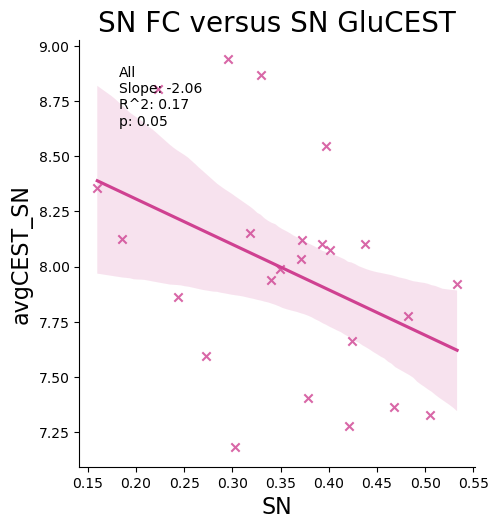

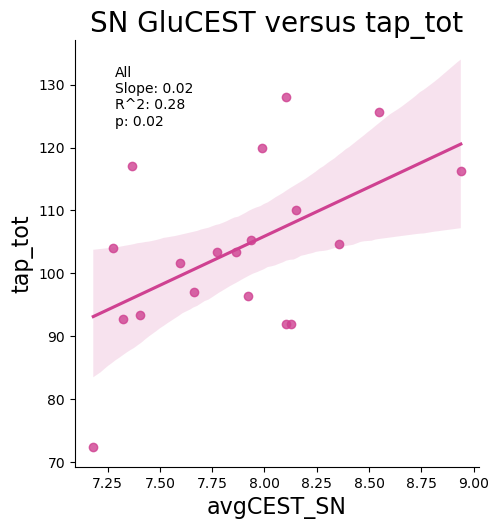

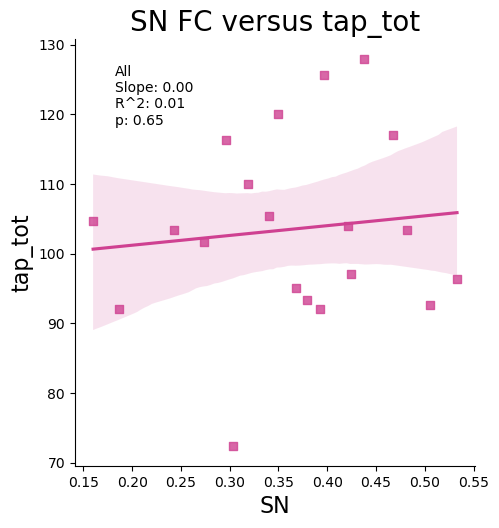

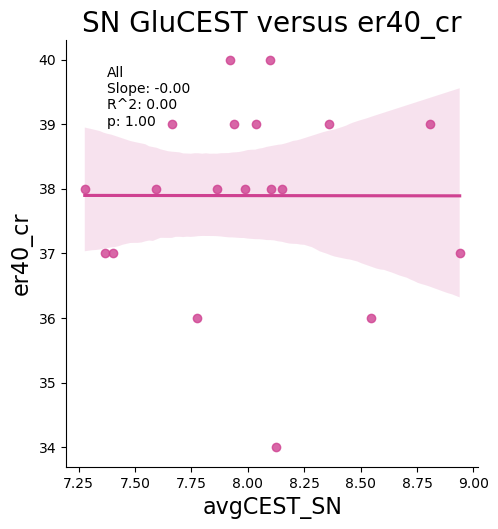

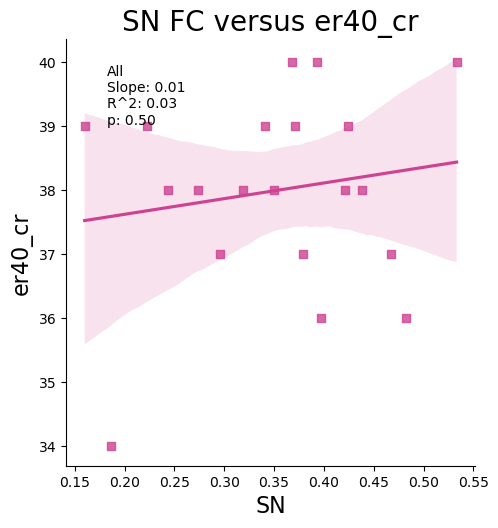

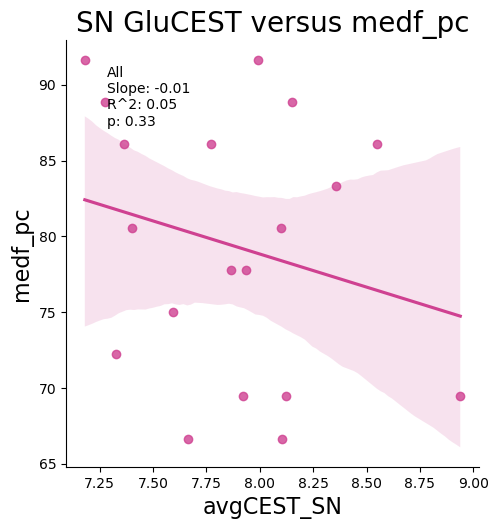

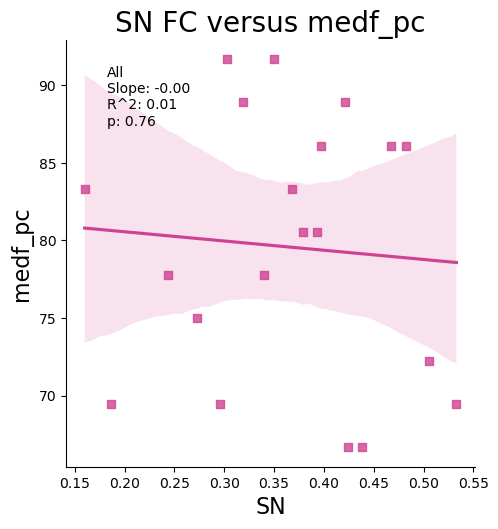

  hstatus_  avgCEST_SalVentAttn_mean  avgCEST_SalVentAttn_std  \
0       HC                  7.795908                 0.543594   
1    Other                  8.162545                 0.520001   
2      PSY                  8.043051                 0.401342   

   SalVentAttn_mean  SalVentAttn_std  
0          0.368396         0.106964  
1          0.329335         0.081924  
2          0.366513         0.084872  


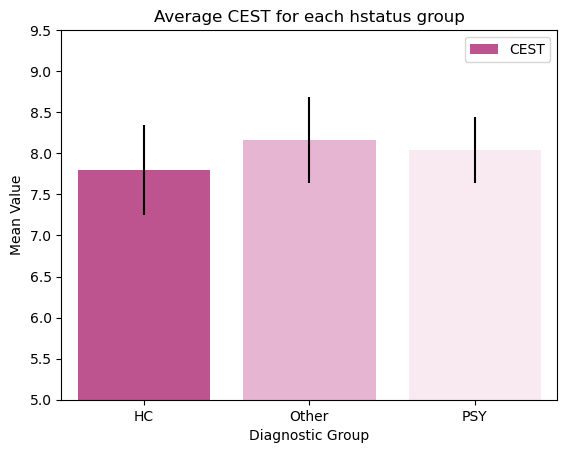

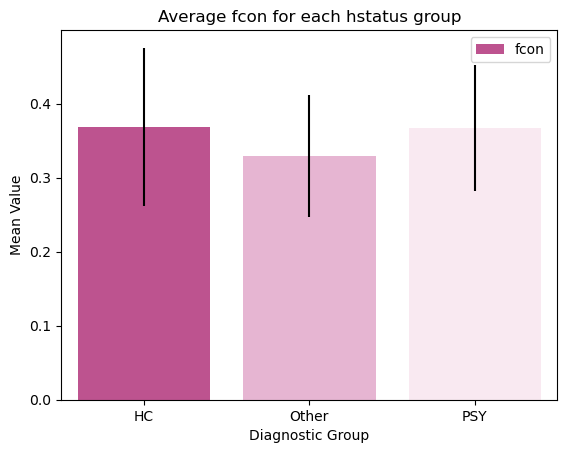

     BBLID Session  sex    age  race  ethnic  dateDiff      Cont   Default  \
0    19830   10789  2.0  21.92   1.0     2.0       0.0  0.175604  0.376170   
1    20645   11260  1.0  19.84   2.0     2.0       0.0       NaN  0.210973   
2   125511   10906  2.0  20.86   1.0     2.0       0.0       NaN  0.260692   
3   116019   11135  2.0  25.72   2.0     1.0       0.0  0.121458  0.322248   
4    19790   10819  2.0  23.37   1.0     2.0       0.0  0.248519  0.331945   
5    80557   10738  2.0  29.28   2.0     2.0       0.0       NaN       NaN   
6    20642   11261  1.0  25.59   NaN     NaN       0.0  0.232299  0.216163   
7    20180   11011  1.0  15.43   1.0     2.0      15.0  0.096672  0.101490   
8   139272   10739  NaN    NaN   NaN     NaN       NaN  0.085998  0.153989   
9   121085   10851  2.0  20.84   1.0     2.0      14.0  0.201904  0.159492   
10   93292   10938  2.0  25.32   2.0     2.0       0.0  0.246400  0.168437   
11   90281   10902  2.0  22.89   1.0     2.0      52.0       NaN

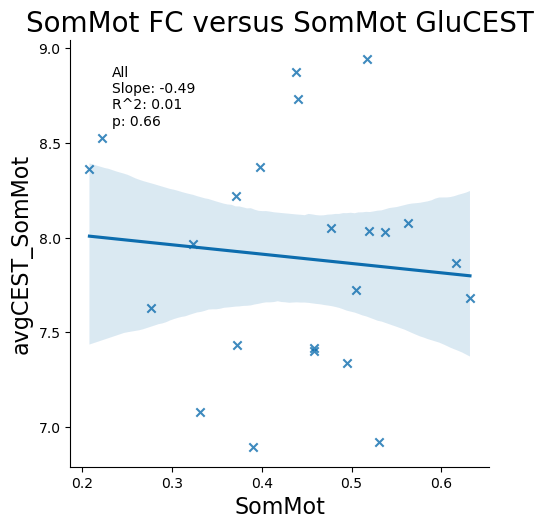

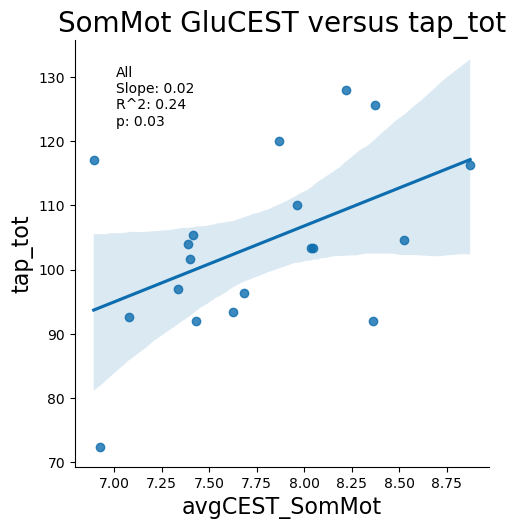

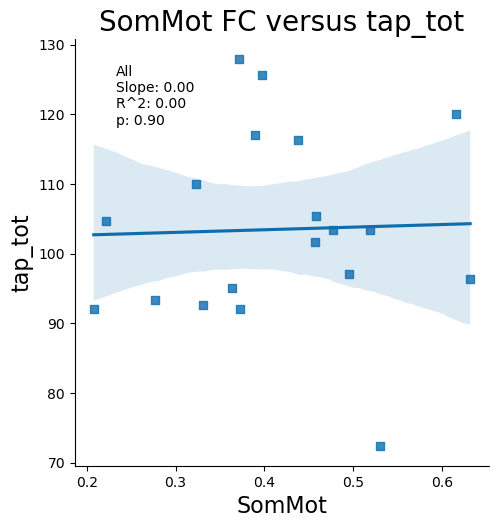

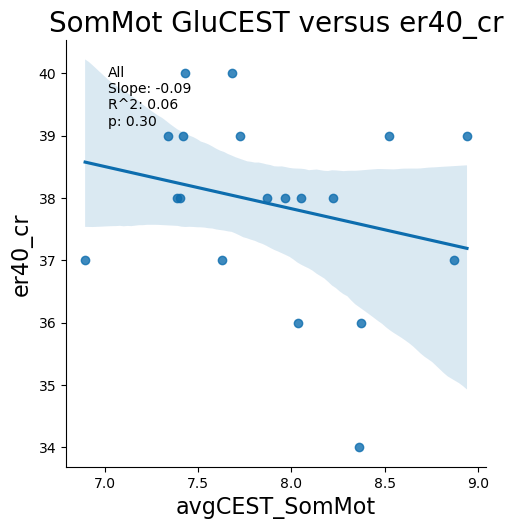

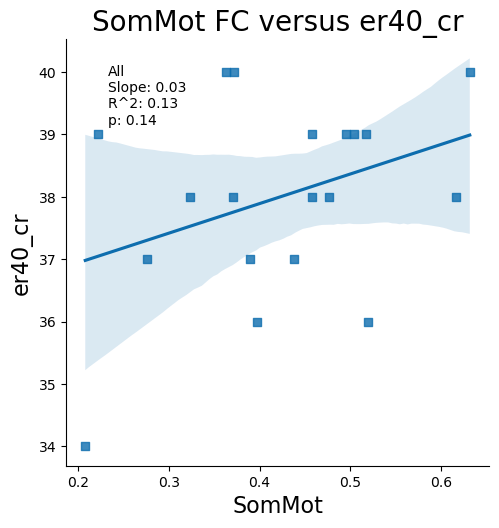

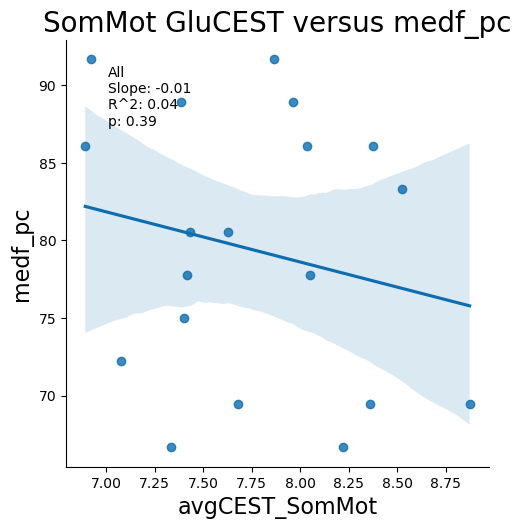

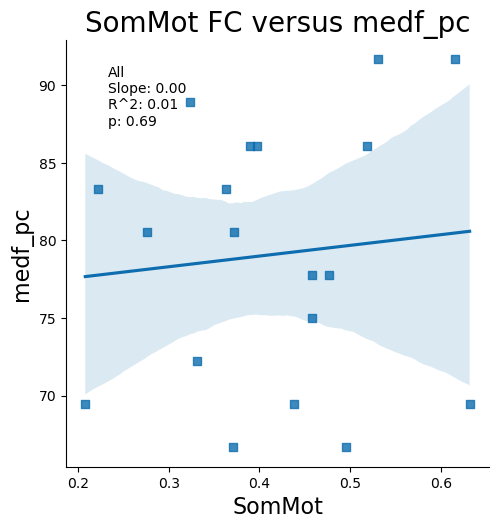

  hstatus_  avgCEST_SomMot_mean  avgCEST_SomMot_std  SomMot_mean  SomMot_std
0       HC             7.627695            0.678048     0.425217    0.098687
1    Other             8.095808            0.601198     0.413422    0.118454
2      PSY             7.970517            0.419776     0.458780    0.122978


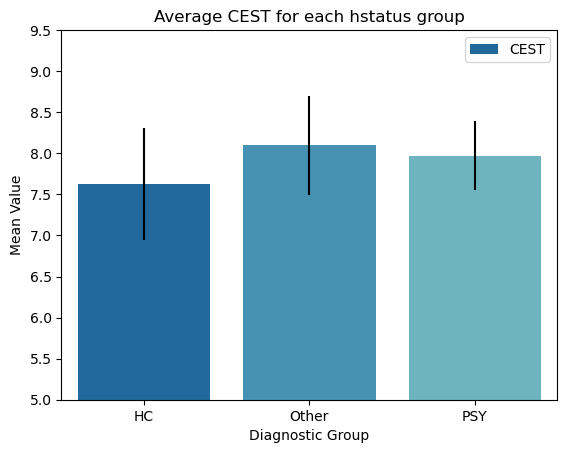

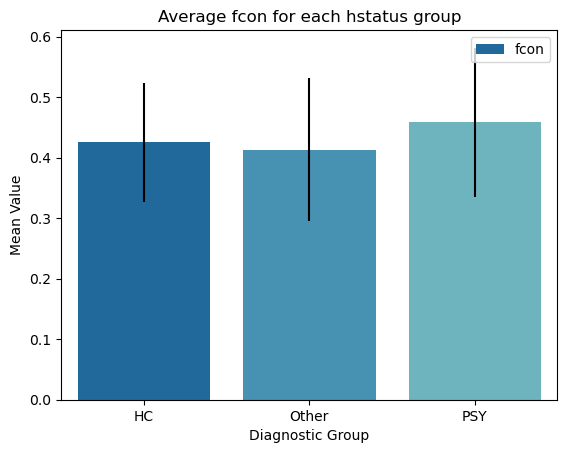

     BBLID Session  sex    age  race  ethnic  dateDiff      Cont   Default  \
0    19830   10789  2.0  21.92   1.0     2.0       0.0  0.175604  0.376170   
1    20645   11260  1.0  19.84   2.0     2.0       0.0       NaN  0.210973   
2   125511   10906  2.0  20.86   1.0     2.0       0.0       NaN  0.260692   
3   116019   11135  2.0  25.72   2.0     1.0       0.0  0.121458  0.322248   
4    19790   10819  2.0  23.37   1.0     2.0       0.0  0.248519  0.331945   
5    80557   10738  2.0  29.28   2.0     2.0       0.0       NaN       NaN   
6    20642   11261  1.0  25.59   NaN     NaN       0.0  0.232299  0.216163   
7    20180   11011  1.0  15.43   1.0     2.0      15.0  0.096672  0.101490   
8   139272   10739  NaN    NaN   NaN     NaN       NaN  0.085998  0.153989   
9   121085   10851  2.0  20.84   1.0     2.0      14.0  0.201904  0.159492   
10   93292   10938  2.0  25.32   2.0     2.0       0.0  0.246400  0.168437   
11   90281   10902  2.0  22.89   1.0     2.0      52.0       NaN

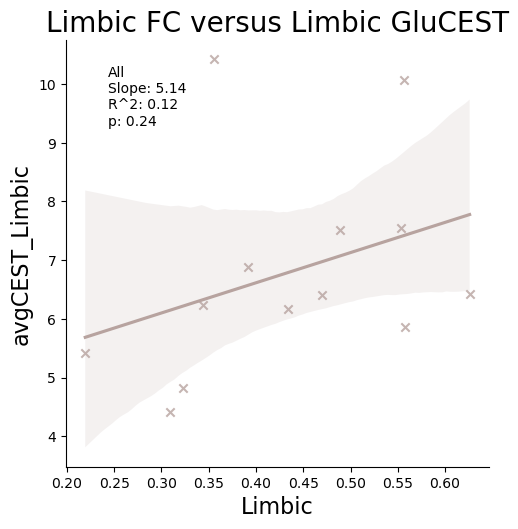

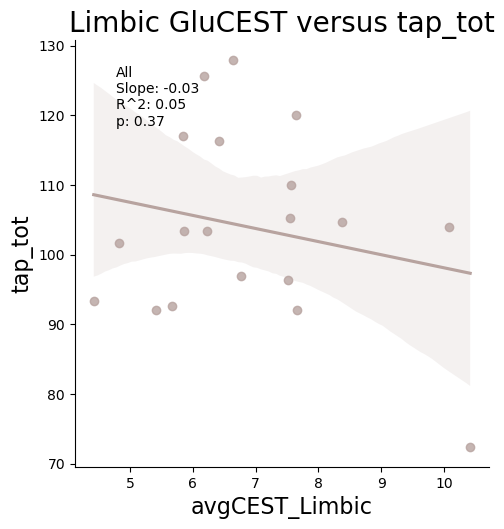

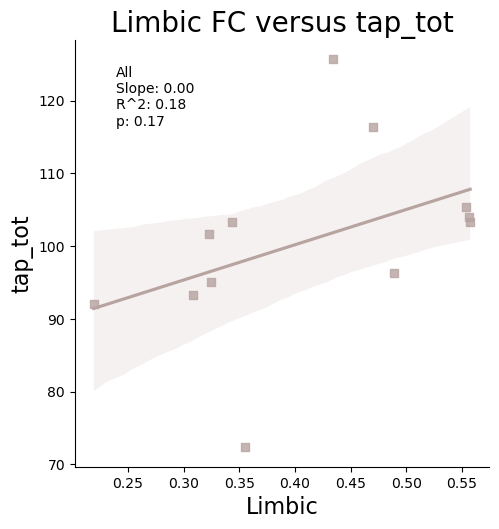

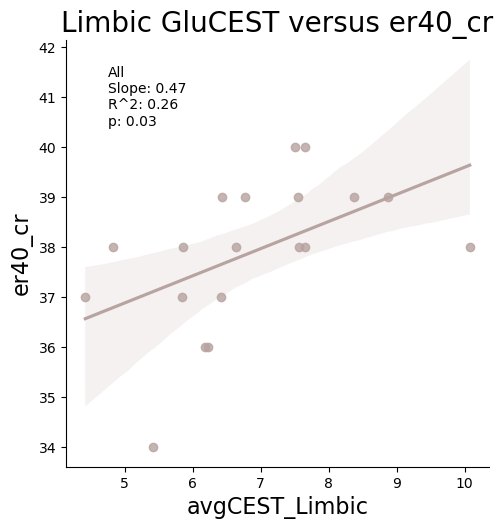

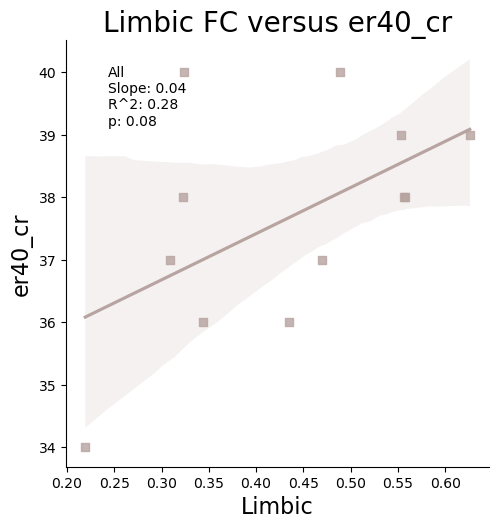

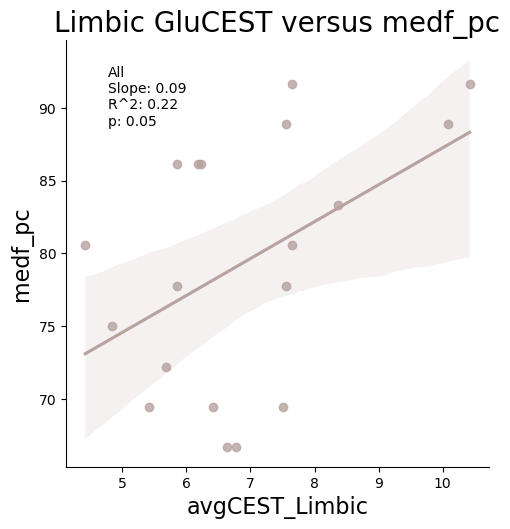

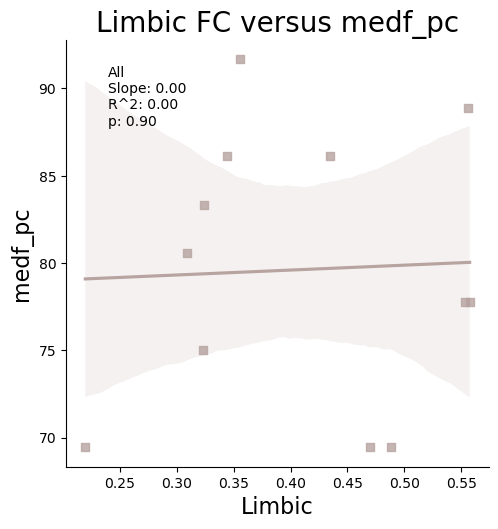

  hstatus_  avgCEST_Limbic_mean  avgCEST_Limbic_std  Limbic_mean  Limbic_std
0       HC             7.099427            1.782223     0.347572    0.028164
1    Other             7.124398            1.632299     0.458920    0.178272
2      PSY             6.742494            1.069243     0.475692    0.100969


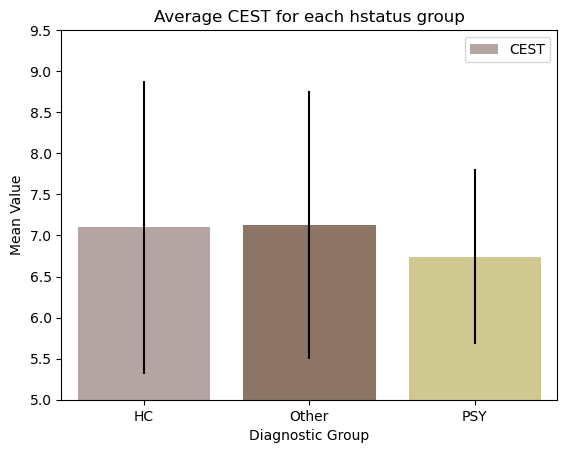

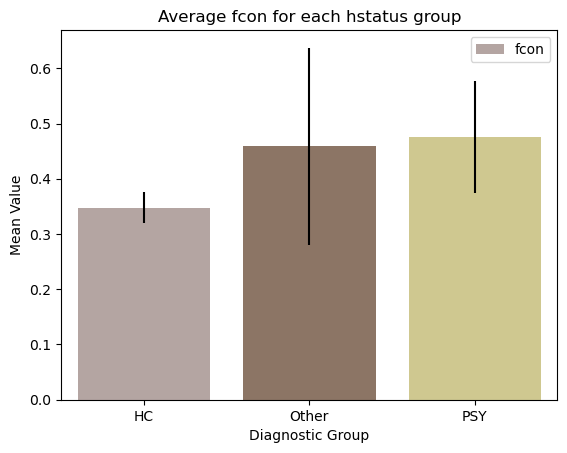

In [25]:
if run_grpanalysis:
    # Curate data 
    value_counts = grp_df['dx_pscat'].value_counts()
    print(value_counts)
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('NC', 'HC')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PROR', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PRO', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('S', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('O', 'Other')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('Unknown', 'Other')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('MDD', 'Other')
    value_counts = grp_df['dx_pscat'].value_counts()
    print(value_counts)
    
    colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
        'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 
        
    # Create a scatter plot with a linear regression line
    for network in networks:
        print(grp_df)
        cestcol = "avgCEST_" + network
        #graph_df = grp_df[grp_df['dx_pscat'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[network, cestcol, 'dx_pscat'])
        # Create a linear regression model for fcon
        color = colors.loc[colors['Network'] == network, 'Color'].values[0]
        sns.set_palette(color)
        plot = sns.lmplot(x=network, y=cestcol, data=graph_df, markers= "x") #hue='dx_pscat', 
        if network == "SalVentAttn":
            plt.xlabel("SN", fontsize=16)
            plt.ylabel("avgCEST_SN", fontsize=16)
            plt.title('SN FC versus SN GluCEST', fontsize = 20)
        else:
            plt.xlabel(network, fontsize=16)
            plt.ylabel(cestcol, fontsize=16)
            plt.title(network + ' FC versus ' + network + ' GluCEST' , fontsize = 20)
        # Generate and add slope, r2 and p for subset 1
 #       slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', network], graph_df.loc[graph_df['dx_pscat'] == 'PSY', cestcol])
 #       plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
   #     # Generate and add slope, r2 and p for subset 2
 #       slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'HC', network], graph_df.loc[graph_df['dx_pscat'] == 'HC', cestcol])
 #       plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df[network], graph_df[cestcol])
        plt.text(0.1, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        plt.show() 

        # Create CNB correlation plot for each network fcon and cest 
        for CNB_score in CNB_scores:
         #   graph_df = grp_df[grp_df['dx_pscat'] != 'Other']
            graph_df = grp_df
            graph_df = graph_df.dropna(subset=[CNB_score, cestcol, 'dx_pscat'])
            # Add labels and a title to the plot
            plot = sns.lmplot(x=cestcol, y=CNB_score,data=graph_df) # hue='dx_pscat',
            if network == "SalVentAttn":
                plt.xlabel("avgCEST_SN", fontsize=16)
                plt.title('SN GluCEST versus ' + CNB_score, fontsize = 20)
            else: 
                plt.xlabel(cestcol, fontsize=16)
                plt.title(network + ' GluCEST versus ' + CNB_score, fontsize = 20)
            plt.ylabel(CNB_score, fontsize=16)
            # Generate and add slope, r2 and p for subset 1
   #         slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', CNB_score], graph_df.loc[graph_df['dx_pscat'] == 'PSY', cestcol])
   #         plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
            # Generate and add slope, r2 and p for subset 2
    #        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'HC', CNB_score], graph_df.loc[graph_df['dx_pscat'] == 'HC', cestcol])
    #        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
            # Generate and add slope, r2 and p for all data
            slope, intercept, r_value, p_value, std_err = linregress(graph_df[CNB_score], graph_df[cestcol])
            plt.text(0.1, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)   
            # Show the plot
            plt.show()    
            
            #graph_df = grp_df[grp_df['dx_pscat'] != 'Other']
            graph_df = grp_df
            graph_df = graph_df.dropna(subset=[CNB_score, network, 'dx_pscat'])
            # Add labels and a title to the plot
            plot = sns.lmplot(x=network, y=CNB_score, data=graph_df, markers= "s") #hue='dx_pscat',
            if network == "SalVentAttn":
                plt.xlabel("SN", fontsize=16)
                plt.title('SN FC versus ' + CNB_score, fontsize = 20)
            else:
                plt.xlabel(network, fontsize=16)
                plt.title(network + ' FC versus ' + CNB_score, fontsize = 20)
            plt.ylabel(CNB_score, fontsize=16)
            # Generate and add slope, r2 and p for subset 1
  #          slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', CNB_score], graph_df.loc[graph_df['dx_pscat'] == 'PSY', network])
  #          plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
            # Generate and add slope, r2 and p for subset 2
   #         slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'HC', CNB_score], graph_df.loc[graph_df['dx_pscat'] == 'HC', network])
   #         plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
            # Generate and add slope, r2 and p for all data
            slope, intercept, r_value, p_value, std_err = linregress(graph_df[CNB_score], graph_df[network])
            plt.text(0.1, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)   
            # Show the plot
            plt.show()  
       
        # Make bar graph comparing diagnostic groups
        avg_df = grp_df.groupby('dx_pscat').agg({cestcol: ['mean', 'std'], network: ['mean', 'std']}).reset_index()
        # Flatten the multi-level columns
        avg_df.columns = ['_'.join(col).strip() for col in avg_df.columns.values]
        print(avg_df)

        # Plot CEST bar graph with error bars
        sns.barplot(x='dx_pscat_', y=cestcol + '_mean', data=avg_df, yerr=avg_df[cestcol + '_std'], label='CEST')
        plt.xlabel('Diagnostic Group')
        plt.ylabel('Mean Value')
        plt.ylim(5, 9.5)
        plt.title('Average CEST for each dx_pscat group')
        plt.legend()
        plt.show()

        # Plot fcon bar graph with error bars
        sns.barplot(x='dx_pscat_', y=network + '_mean', data=avg_df, yerr=avg_df[network + '_std'], label='fcon')
        plt.xlabel('Diagnostic Group')
        plt.ylabel('Mean Value')
        plt.title('Average fcon for each dx_pscat group')
        plt.legend()
        plt.show()
        
        # Make bar graph comparing network-level CEST and fcon levels
        #

hstatus
NC         23
PRO        17
Unknown     6
S           6
PSY         4
O           2
PROR        2
MDD         2
Name: count, dtype: int64
hstatus
PSY      29
HC       23
Other    10
Name: count, dtype: int64
Intercept: 98.15734353062948
Coefficients: avgCEST_Cont     2.697674
Cont           -59.573144
dtype: float64
Cont-tap_tot ANOVA Results:
                   sum_sq    df         F    PR(>F)
avgCEST_Cont    65.282549   1.0  0.470055  0.497478
Cont           620.575015   1.0  4.468335  0.041727
Residual      4860.899631  35.0       NaN       NaN
Intercept: 29.333477223416942
Coefficients: avgCEST_Cont    1.077393
Cont           -3.241797
dtype: float64
Cont-er40_cr ANOVA Results:
                  sum_sq    df         F   PR(>F)
avgCEST_Cont    9.940285   1.0  2.200472  0.14718
Cont            1.800830   1.0  0.398648  0.53201
Residual      153.589643  34.0       NaN      NaN
Intercept: 115.79929901723546
Coefficients: avgCEST_Cont   -4.534770
Cont            7.701735
dtype: 

/var/folders/ls/hy_z7hgd4_13km3h7j84vqh40000gp/T/ipykernel_3148/2516526184.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Intercept:', model.params[0])
/var/folders/ls/hy_z7hgd4_13km3h7j84vqh40000gp/T/ipykernel_3148/2516526184.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Intercept:', model.params[0])
/var/folders/ls/hy_z7hgd4_13km3h7j84vqh40000gp/T/ipykernel_3148/2516526184.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

Intercept: 33.82998607543426
Coefficients: avgCEST_Limbic    0.551864
Limbic            0.235921
dtype: float64
Limbic-er40_cr ANOVA Results:
                   sum_sq    df         F    PR(>F)
avgCEST_Limbic  11.949987   1.0  3.055763  0.099610
Limbic           0.015180   1.0  0.003882  0.951094
Residual        62.570223  16.0       NaN       NaN
Intercept: 97.47546461686645
Coefficients: avgCEST_Limbic    -0.436728
Limbic           -31.264380
dtype: float64
Limbic-medf_pc ANOVA Results:
                     sum_sq    df         F    PR(>F)
avgCEST_Limbic    10.352499   1.0  0.137690  0.714920
Limbic           287.530662   1.0  3.824205  0.066223
Residual        1353.366817  18.0       NaN       NaN


/var/folders/ls/hy_z7hgd4_13km3h7j84vqh40000gp/T/ipykernel_3148/2516526184.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Intercept:', model.params[0])


hstatus
NC         10
PRO         7
Unknown     4
O           3
MDD         3
PSY         2
Name: count, dtype: int64
hstatus
HC       10
Other    10
PSY       9
Name: count, dtype: int64



Cont & tap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.126
Method:                 Least Squares   F-statistic:                    0.1631
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.851
Time:                        19:10:01   Log-Likelihood:                -61.774
No. Observations:                  16   AIC:                             129.5
Df Residuals:                      13   BIC:                             131.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
    

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


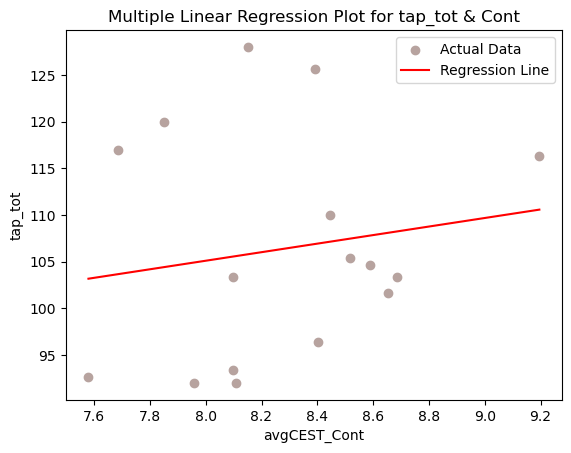




Cont & er40_cr
                            OLS Regression Results                            
Dep. Variable:                er40_cr   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                 -0.076
Method:                 Least Squares   F-statistic:                    0.4322
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.657
Time:                        19:10:02   Log-Likelihood:                -30.555
No. Observations:                  17   AIC:                             67.11
Df Residuals:                      14   BIC:                             69.61
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       33.6264      9

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


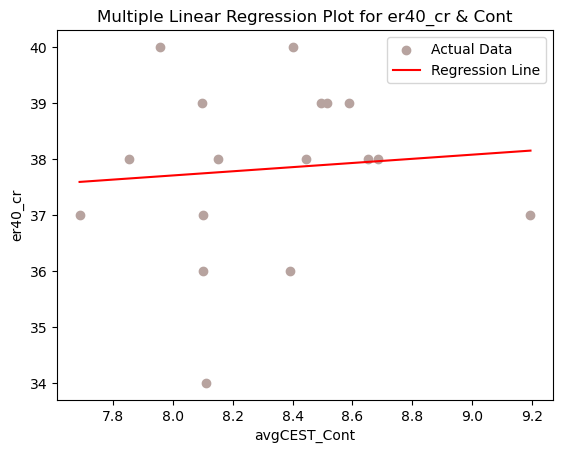




Cont & medf_pc
                            OLS Regression Results                            
Dep. Variable:                medf_pc   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.059
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.375
Time:                        19:10:02   Log-Likelihood:                -53.945
No. Observations:                  16   AIC:                             113.9
Df Residuals:                      13   BIC:                             116.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      130.7061     41

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


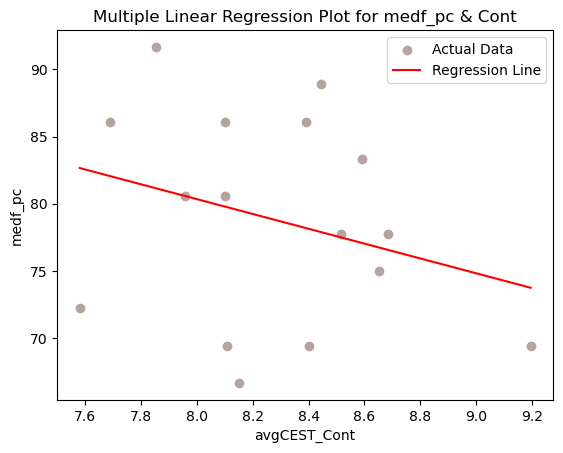




Default & tap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.088
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.364
Time:                        19:10:02   Log-Likelihood:                -64.073
No. Observations:                  17   AIC:                             134.1
Df Residuals:                      14   BIC:                             136.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         156

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


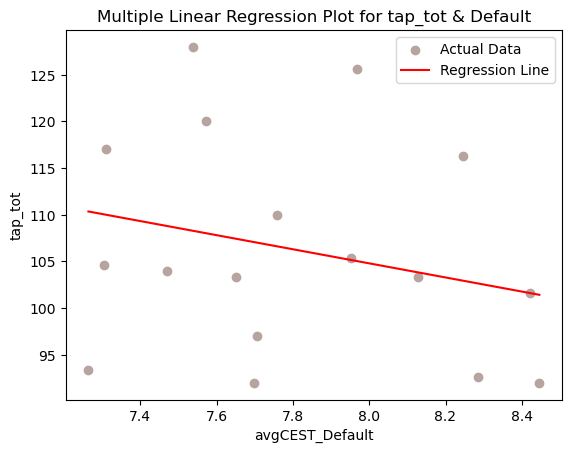




Default & er40_cr


/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                er40_cr   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.090
Method:                 Least Squares   F-statistic:                    0.2968
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.747
Time:                        19:10:02   Log-Likelihood:                -31.205
No. Observations:                  18   AIC:                             68.41
Df Residuals:                      15   BIC:                             71.08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          35.1400      7.562     

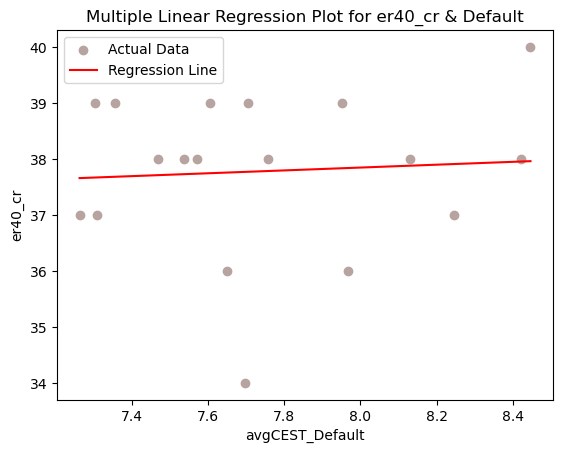




Default & medf_pc
                            OLS Regression Results                            
Dep. Variable:                medf_pc   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     2.604
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.109
Time:                        19:10:03   Log-Likelihood:                -56.738
No. Observations:                  17   AIC:                             119.5
Df Residuals:                      14   BIC:                             122.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         136

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


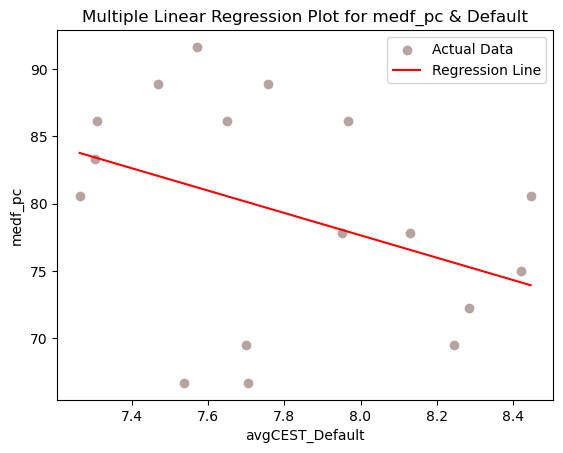




DorsAttn & tap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.049
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.373
Time:                        19:10:03   Log-Likelihood:                -74.806
No. Observations:                  19   AIC:                             155.6
Df Residuals:                      16   BIC:                             158.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


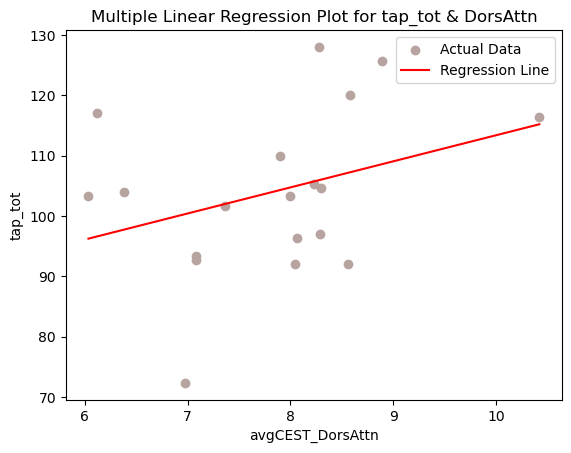




DorsAttn & er40_cr
                            OLS Regression Results                            
Dep. Variable:                er40_cr   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     1.842
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.191
Time:                        19:10:03   Log-Likelihood:                -32.014
No. Observations:                  19   AIC:                             70.03
Df Residuals:                      16   BIC:                             72.86
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


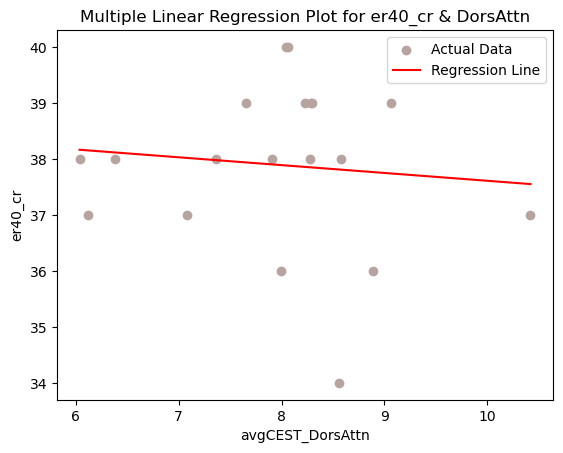




DorsAttn & medf_pc
                            OLS Regression Results                            
Dep. Variable:                medf_pc   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1.407
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.274
Time:                        19:10:03   Log-Likelihood:                -65.796
No. Observations:                  19   AIC:                             137.6
Df Residuals:                      16   BIC:                             140.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


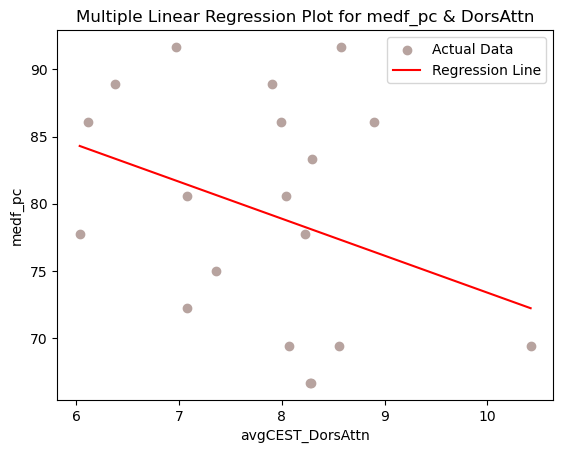




Vis & tap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                 -0.056
Method:                 Least Squares   F-statistic:                    0.5497
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.588
Time:                        19:10:04   Log-Likelihood:                -71.408
No. Observations:                  18   AIC:                             148.8
Df Residuals:                      15   BIC:                             151.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     122.9184     21.652

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


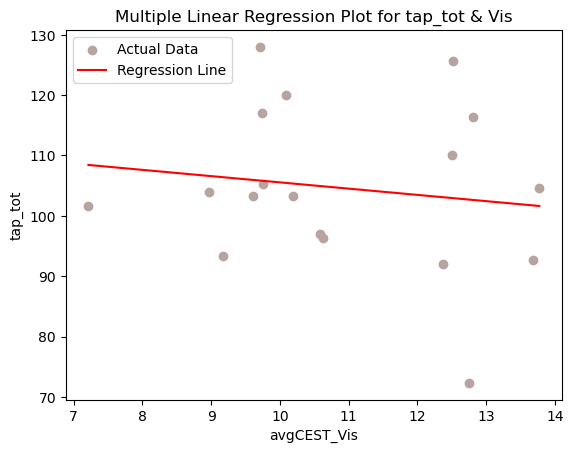




Vis & er40_cr
                            OLS Regression Results                            
Dep. Variable:                er40_cr   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                 -0.079
Method:                 Least Squares   F-statistic:                    0.3743
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.694
Time:                        19:10:04   Log-Likelihood:                -27.608
No. Observations:                  18   AIC:                             61.22
Df Residuals:                      15   BIC:                             63.89
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      36.5451      2.017

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


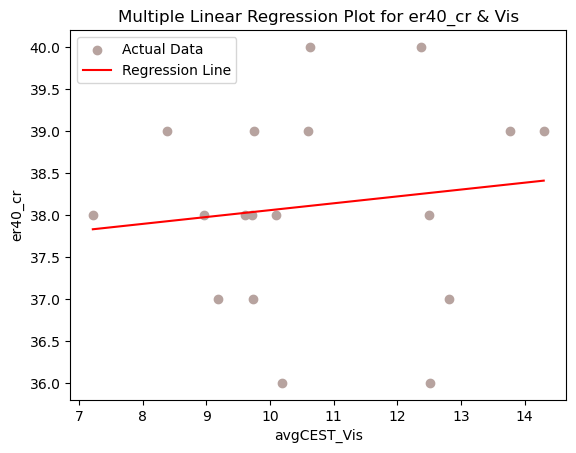




Vis & medf_pc
                            OLS Regression Results                            
Dep. Variable:                medf_pc   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.6777
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.523
Time:                        19:10:04   Log-Likelihood:                -62.765
No. Observations:                  18   AIC:                             131.5
Df Residuals:                      15   BIC:                             134.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      80.9322     13.396

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


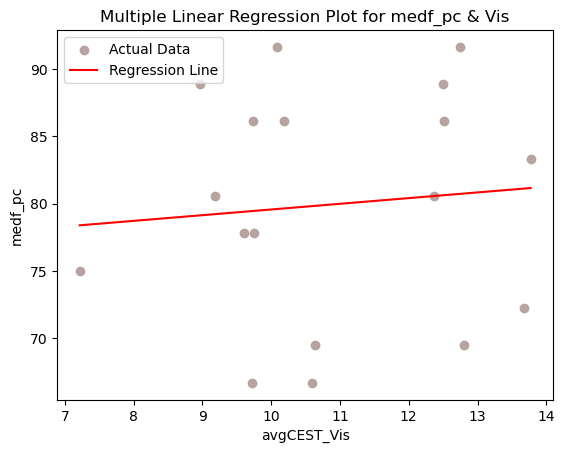




SalVentAttn & tap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     4.960
Date:                Tue, 16 Jan 2024   Prob (F-statistic):             0.0211
Time:                        19:10:04   Log-Likelihood:                -71.393
No. Observations:                  19   AIC:                             148.8
Df Residuals:                      16   BIC:                             151.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


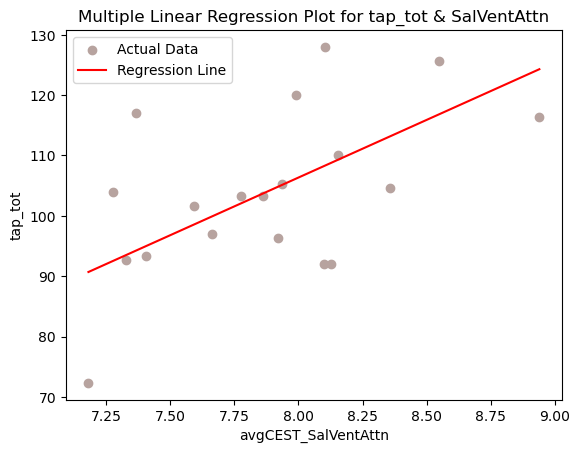




SalVentAttn & er40_cr
                            OLS Regression Results                            
Dep. Variable:                er40_cr   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                 -0.090
Method:                 Least Squares   F-statistic:                    0.2542
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.779
Time:                        19:10:05   Log-Likelihood:                -33.685
No. Observations:                  19   AIC:                             73.37
Df Residuals:                      16   BIC:                             76.20
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


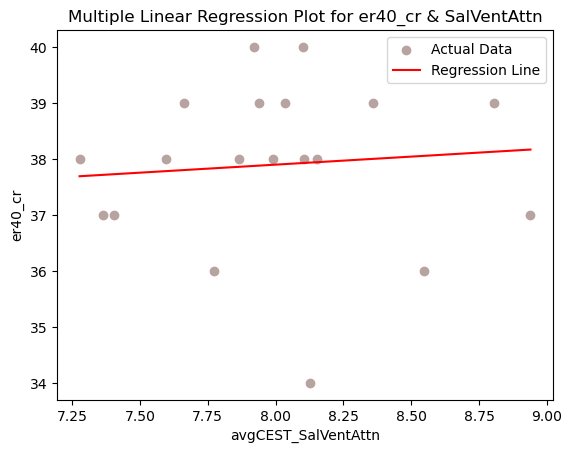




SalVentAttn & medf_pc
                            OLS Regression Results                            
Dep. Variable:                medf_pc   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.7200
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.502
Time:                        19:10:05   Log-Likelihood:                -66.516
No. Observations:                  19   AIC:                             139.0
Df Residuals:                      16   BIC:                             141.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


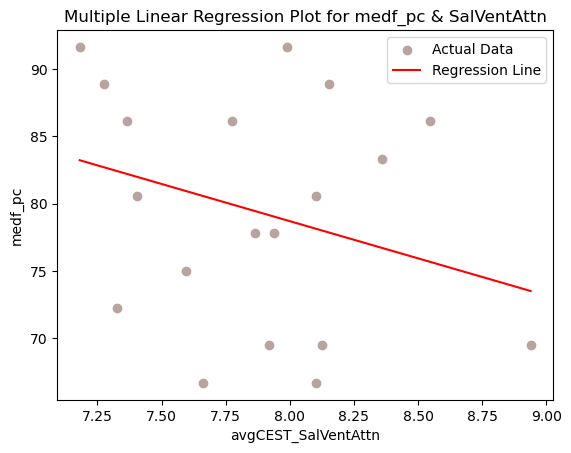




SomMot & tap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     2.703
Date:                Tue, 16 Jan 2024   Prob (F-statistic):             0.0994
Time:                        19:10:05   Log-Likelihood:                -69.694
No. Observations:                  18   AIC:                             145.4
Df Residuals:                      15   BIC:                             148.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.278

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


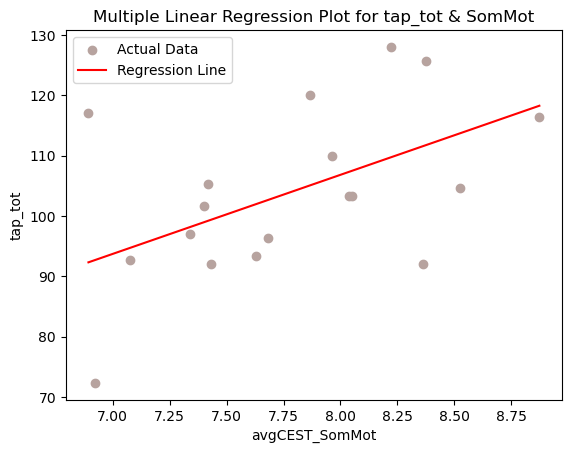




SomMot & er40_cr
                            OLS Regression Results                            
Dep. Variable:                er40_cr   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     1.989
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.171
Time:                        19:10:05   Log-Likelihood:                -30.560
No. Observations:                  18   AIC:                             67.12
Df Residuals:                      15   BIC:                             69.79
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         40.029

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


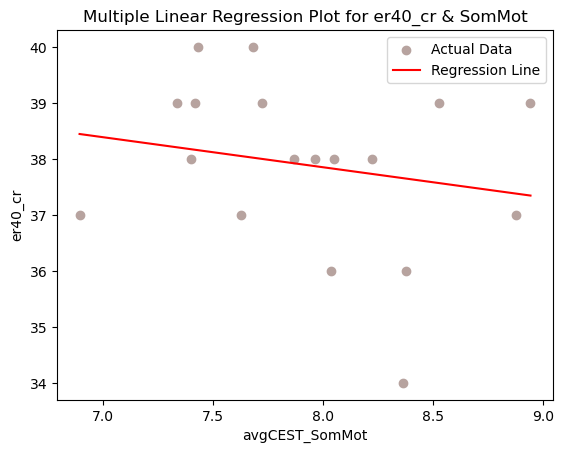




SomMot & medf_pc
                            OLS Regression Results                            
Dep. Variable:                medf_pc   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.093
Method:                 Least Squares   F-statistic:                    0.2757
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.763
Time:                        19:10:06   Log-Likelihood:                -63.285
No. Observations:                  18   AIC:                             132.6
Df Residuals:                      15   BIC:                             135.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         95.122

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


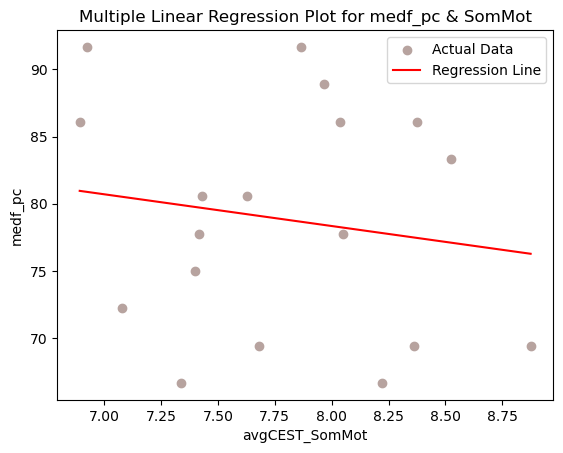




Limbic & tap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     3.716
Date:                Tue, 16 Jan 2024   Prob (F-statistic):             0.0722
Time:                        19:10:06   Log-Likelihood:                -40.228
No. Observations:                  11   AIC:                             86.46
Df Residuals:                       8   BIC:                             87.65
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         97.858

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


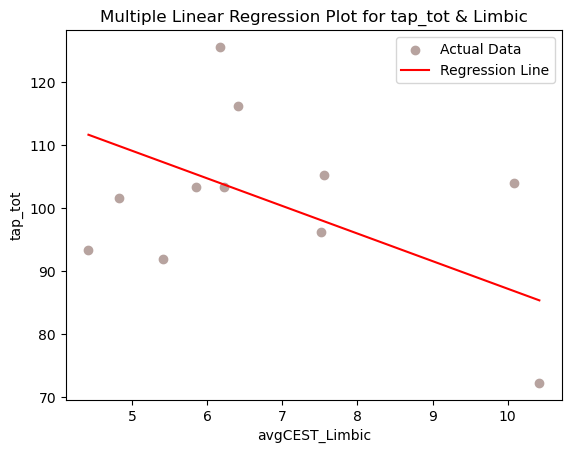




Limbic & er40_cr
                            OLS Regression Results                            
Dep. Variable:                er40_cr   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     4.774
Date:                Tue, 16 Jan 2024   Prob (F-statistic):             0.0432
Time:                        19:10:06   Log-Likelihood:                -16.568
No. Observations:                  11   AIC:                             39.14
Df Residuals:                       8   BIC:                             40.33
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         33.496

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


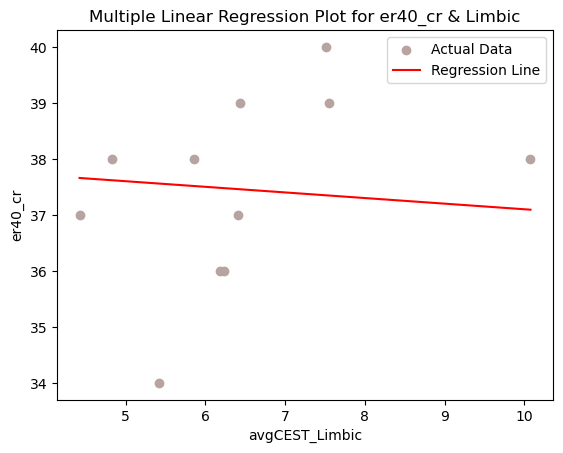




Limbic & medf_pc
                            OLS Regression Results                            
Dep. Variable:                medf_pc   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     1.826
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.222
Time:                        19:10:07   Log-Likelihood:                -36.007
No. Observations:                  11   AIC:                             78.01
Df Residuals:                       8   BIC:                             79.21
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         67.379

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


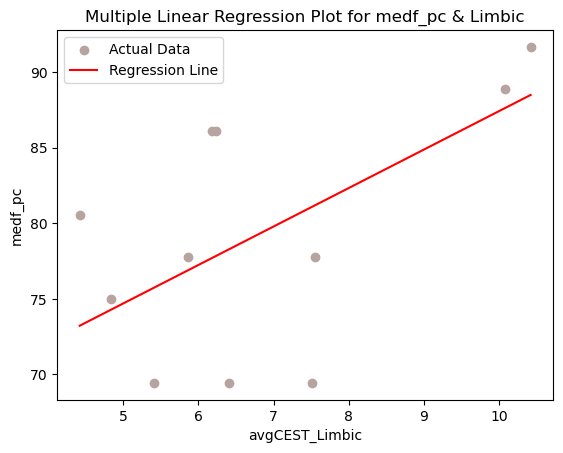

In [127]:
#CLUNKIER COMPREHENSIVE VERSION:

from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf

if run_grpanalysis:
    # Curate data 
    value_counts = grp_df['dx_pscat'].value_counts()
    print(value_counts)
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('NC', 'HC')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PROR', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PRO', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('S', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('O', 'Other')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('Unknown', 'Other')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('MDD', 'Other')
    value_counts = grp_df['dx_pscat'].value_counts()
    print(value_counts)
    
    colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
        'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 
    
    anova_tables = []
    # Create a scatter plot with a multiple linear regression 
    for network in networks:
        cestcol = "avgCEST_" + network
        # Create a linear regression model for fcon
       # color = colors.loc[colors['Network'] == network, 'Color'].values[0]
       # sns.set_palette(color)

        # Create CNB correlation plot for each network fcon and cest 
        for CNB_score in CNB_scores:
         #   graph_df = grp_df[grp_df['dx_pscat'] != 'Other']
            graph_df = grp_df
            graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
            graph_df = graph_df[[CNB_score, cestcol, network]]
            # Define x values and target variable
            X = graph_df[[cestcol, network]]
            Y = graph_df[CNB_score]

            ##################################
            # Define formula and model
            formula = f'{CNB_score} ~ {cestcol} + {network}'
            model = smf.ols(formula=formula, data=graph_df).fit()
            print('\n\n\n' + network + ' & ' + CNB_score) 
            print(model.summary())

            # Plotting the regression line
            fig, ax = plt.subplots()
            ax.scatter(graph_df[cestcol], graph_df[CNB_score], label='Actual Data')
            # Generate x values for the line
            x_line = pd.DataFrame({cestcol: np.linspace(graph_df[cestcol].min(), graph_df[cestcol].max(), 100),
                                   network: np.mean(graph_df[network])})  # Use mean value for the network variable
            # Predictions for the regression line
            y_line = model.predict(x_line)
            # Plot the regression line
            ax.plot(x_line[cestcol], y_line, color='red', label='Regression Line')
            ax.set_xlabel(cestcol)
            ax.set_ylabel(CNB_score)
            ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + network)
            ax.legend()
            plt.show()


In [113]:
#CLUNKIER COMPREHENSIVE VERSION:

from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf

if run_grpanalysis:
    # Curate data 
    value_counts = grp_df['dx_pscat'].value_counts()
    print(value_counts)
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('NC', 'HC')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PROR', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PRO', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('S', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('O', 'Other')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('Unknown', 'Other')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('MDD', 'Other')
    value_counts = grp_df['dx_pscat'].value_counts()
    print(value_counts)
    
    colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
        'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 
    
    anova_tables = []
    # Create a scatter plot with a multiple linear regression 
    for network in networks:
        cestcol = "avgCEST_" + network
        # Create a linear regression model for fcon
       # color = colors.loc[colors['Network'] == network, 'Color'].values[0]
       # sns.set_palette(color)

        # Create CNB correlation plot for each network fcon and cest 
        for CNB_score in CNB_scores:
         #   graph_df = grp_df[grp_df['dx_pscat'] != 'Other']
            graph_df = grp_df
            graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
            graph_df = graph_df[[CNB_score, cestcol, network]]
            # Define x values and target variable
            X = graph_df[[cestcol, network]]
            Y = graph_df[CNB_score]
            
            ##################################
            # Define formula and model
            formula = f'{CNB_score} ~ {cestcol} + {network}'
            model = smf.ols(formula=formula, data=graph_df).fit()
            print(network + CNB_score)
            print(model.summary())
            
            


hstatus
PSY      29
HC       23
Other    10
Name: count, dtype: int64
hstatus
PSY      29
HC       23
Other    10
Name: count, dtype: int64
Conttap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2.296
Date:                Tue, 16 Jan 2024   Prob (F-statistic):              0.116
Time:                        18:44:56   Log-Likelihood:                -146.10
No. Observations:                  38   AIC:                             298.2
Df Residuals:                      35   BIC:                             303.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|  

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
######## OLD CODE

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

if run_grpanalysis:
    # Curate data 
    value_counts = grp_df['dx_pscat'].value_counts()
    print(value_counts)
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('NC', 'HC')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PROR', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PRO', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('S', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('O', 'Other')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('Unknown', 'Other')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('MDD', 'Other')
    value_counts = grp_df['dx_pscat'].value_counts()
    print(value_counts)

    anova_tables = []
    for network in networks:
        cestcol = "avgCEST_" + network
        
        for CNB_score in CNB_scores:
         #   graph_df = grp_df[grp_df['dx_pscat'] != 'Other']
            graph_df = grp_df
            graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
            graph_df = graph_df[[CNB_score, cestcol, network]]

            ##################################
            # Define Linear Regression formula and model
            formula = f'{CNB_score} ~ {cestcol} + {network}'
            model = smf.ols(formula=formula, data=graph_df).fit()

            print('Intercept:', model.params[0])
            print('Coefficients:', model.params[1:])

            # Perform ANOVA and print results
            anova_table = sm.stats.anova_lm(model, typ=2)
            anova_tables.append(anova_table)
            print(network + "-" + CNB_score + " ANOVA Results:")
            print(anova_table)
            
            
            
            
            
            
            
            
            
            
            
            
              # Adjust diagnostic Labels
        value_counts = grp_df['dx_pscat'].value_counts()
        print(value_counts)
        grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PROR', 'PSY')
        grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PRO', 'PSY')
        grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('S', 'PSY')
        grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('O', 'Other')
        grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('Unknown', 'Other')
        grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('MDD', 'Other')
        grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('NaN', 'Other')
        
        value_counts = grp_df['dx_pscat'].value_counts()
        print(value_counts)
        print(grp_df)
        # Make bar graph comparing diagnostic groups
        avg_df = graph_df.groupby('dx_pscat').agg({cestcol: ['mean', 'std'], network: ['mean', 'std']}).reset_index()
        # Flatten the multi-level columns
        avg_df.columns = ['_'.join(col).strip() for col in avg_df.columns.values]
        print(avg_df)
 
        colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
        'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'Blues_d', 'terrain_r']}) # 

    
for network in networks:
    cestcol = "avgCEST_" + network
  #  graph_df = grp_df[grp_df['dx_pscat'] != 'Other']
    graph_df = graph_df.dropna(subset=[network, cestcol, 'dx_pscat'])
    # Create a linear regression model for fcon
    color = colors.loc[palette['Network'] == network, 'Color'].values[0]
    sns.set_palette(color)
    plot = sns.lmplot(x=network, y=cestcol,  data=graph_df) #hue='dx_pscat',
    if network == "SalVentAttn":
        print("yes")
        plt.xlabel("SN")
    else:
        plt.xlabel(network)
    plt.ylabel(cestcol)
    # Generate and add slope, r2 and p for subset 1
    slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', network], graph_df.loc[graph_df['dx_pscat'] == 'PSY', cestcol])
    plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    # Generate and add slope, r2 and p for subset 2
    slope, intercept, r_value, p_value, std_err = linregress(graph_df[network], graph_df[cestcol])
    plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    
    plt.title('Linear Regression between ' + network + ' fcon and ' + network + ' cest')
    plt.show() 
        

hstatus
HC       10
Other    10
PSY       9
Name: count, dtype: int64
hstatus
HC       10
Other    10
PSY       9
Name: count, dtype: int64
      tap_tot  avgCEST_Cont      Cont
3   103.33330      8.684751  0.121458
7    92.00000      8.109159  0.096672
10  105.33330      8.515892  0.246400
13  116.33330      9.195672  0.222760
14   92.66666      7.579884  0.341071
15   93.33333      8.099021  0.165071
16  117.00000      7.687283  0.169243
17  103.33330      8.099098  0.261861
18  128.00000      8.151035  0.231845
19  120.00000      7.851769  0.201449
24   96.33333      8.402123  0.233773
25  110.00000      8.444942  0.201716
26  101.66670      8.653494  0.243740
27   92.00000      7.956718  0.119005
30  104.66670      8.590144  0.102177
31  125.66670      8.391536  0.128059


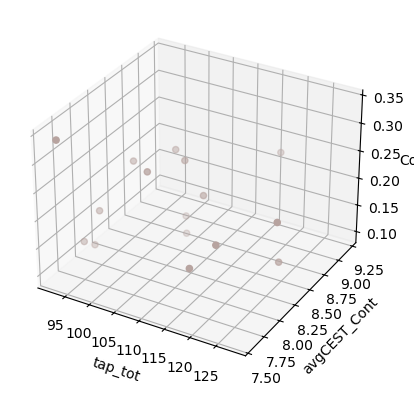

    er40_cr  avgCEST_Cont      Cont
0      39.0      8.496428  0.175604
3      38.0      8.684751  0.121458
4      39.0      8.097737  0.248519
7      34.0      8.109159  0.096672
10     39.0      8.515892  0.246400
13     37.0      9.195672  0.222760
15     37.0      8.099021  0.165071
16     37.0      7.687283  0.169243
17     36.0      8.099098  0.261861
18     38.0      8.151035  0.231845
19     38.0      7.851769  0.201449
24     40.0      8.402123  0.233773
25     38.0      8.444942  0.201716
26     38.0      8.653494  0.243740
27     40.0      7.956718  0.119005
30     39.0      8.590144  0.102177
31     36.0      8.391536  0.128059


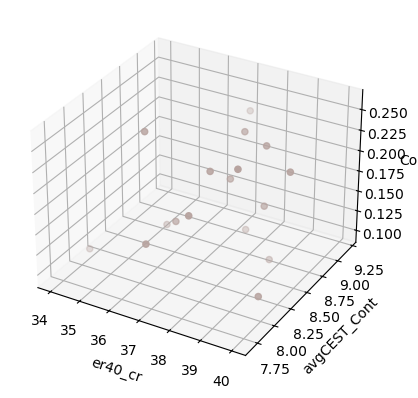

      medf_pc  avgCEST_Cont      Cont
3   77.777778      8.684751  0.121458
7   69.444444      8.109159  0.096672
10  77.777778      8.515892  0.246400
13  69.444444      9.195672  0.222760
14  72.222222      7.579884  0.341071
15  80.555556      8.099021  0.165071
16  86.111111      7.687283  0.169243
17  86.111111      8.099098  0.261861
18  66.666667      8.151035  0.231845
19  91.666667      7.851769  0.201449
24  69.444444      8.402123  0.233773
25  88.888889      8.444942  0.201716
26  75.000000      8.653494  0.243740
27  80.555556      7.956718  0.119005
30  83.333333      8.590144  0.102177
31  86.111111      8.391536  0.128059


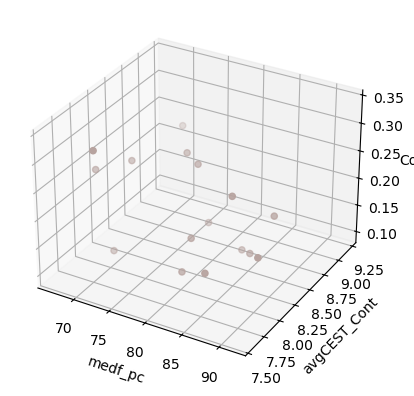

      tap_tot  avgCEST_Default   Default
2   104.00000         7.469096  0.260692
3   103.33330         8.128972  0.322248
7    92.00000         7.698660  0.101490
10  105.33330         7.951705  0.168437
11   97.00000         7.705413  0.235045
13  116.33330         8.244459  0.233656
14   92.66666         8.285107  0.069097
15   93.33333         7.263857  0.196767
16  117.00000         7.310467  0.402548
17  103.33330         7.649832  0.323492
18  128.00000         7.537559  0.195510
19  120.00000         7.571108  0.240199
25  110.00000         7.758677  0.156970
26  101.66670         8.420564  0.267923
27   92.00000         8.445907  0.399663
30  104.66670         7.303762  0.097644
31  125.66670         7.966794  0.364319


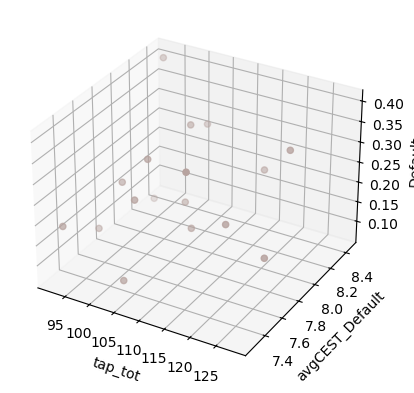

    er40_cr  avgCEST_Default   Default
0      39.0         7.605122  0.376170
2      38.0         7.469096  0.260692
3      38.0         8.128972  0.322248
4      39.0         7.356575  0.331945
7      34.0         7.698660  0.101490
10     39.0         7.951705  0.168437
11     39.0         7.705413  0.235045
13     37.0         8.244459  0.233656
15     37.0         7.263857  0.196767
16     37.0         7.310467  0.402548
17     36.0         7.649832  0.323492
18     38.0         7.537559  0.195510
19     38.0         7.571108  0.240199
25     38.0         7.758677  0.156970
26     38.0         8.420564  0.267923
27     40.0         8.445907  0.399663
30     39.0         7.303762  0.097644
31     36.0         7.966794  0.364319


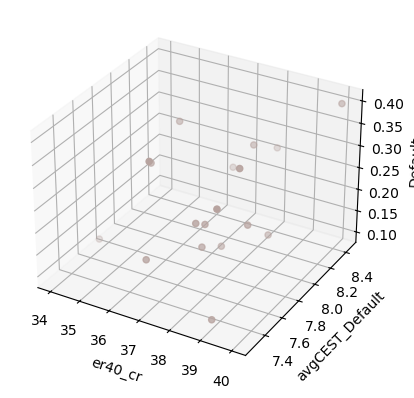

      medf_pc  avgCEST_Default   Default
2   88.888889         7.469096  0.260692
3   77.777778         8.128972  0.322248
7   69.444444         7.698660  0.101490
10  77.777778         7.951705  0.168437
11  66.666667         7.705413  0.235045
13  69.444444         8.244459  0.233656
14  72.222222         8.285107  0.069097
15  80.555556         7.263857  0.196767
16  86.111111         7.310467  0.402548
17  86.111111         7.649832  0.323492
18  66.666667         7.537559  0.195510
19  91.666667         7.571108  0.240199
25  88.888889         7.758677  0.156970
26  75.000000         8.420564  0.267923
27  80.555556         8.445907  0.399663
30  83.333333         7.303762  0.097644
31  86.111111         7.966794  0.364319


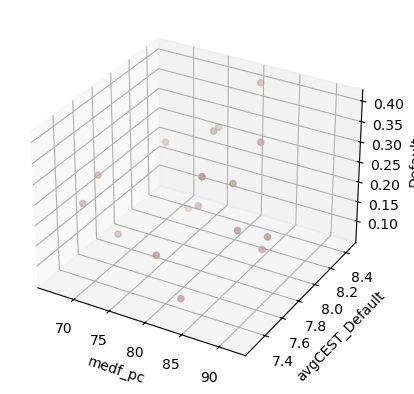

      tap_tot  avgCEST_DorsAttn  DorsAttn
2   104.00000          6.382527  0.258377
3   103.33330          6.035932  0.287490
5    72.33333          6.972563  0.316759
7    92.00000          8.559614  0.063928
10  105.33330          8.223989  0.243422
11   97.00000          8.287902  0.429669
13  116.33330         10.419630  0.278428
14   92.66666          7.080233  0.176538
15   93.33333          7.078968  0.330240
16  117.00000          6.118033  0.309288
17  103.33330          7.992198  0.510831
18  128.00000          8.277535  0.200455
19  120.00000          8.579904  0.335207
24   96.33333          8.066102  0.401307
25  110.00000          7.902069  0.219597
26  101.66670          7.363532  0.494674
27   92.00000          8.043687  0.631075
30  104.66670          8.293079  0.313409
31  125.66670          8.892468  0.473277


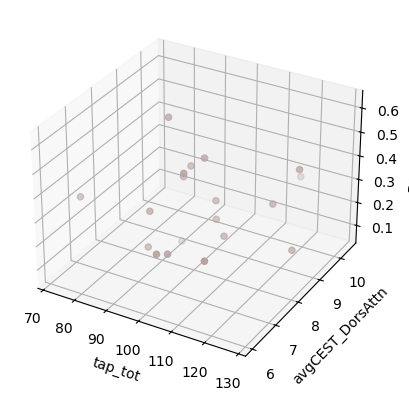

    er40_cr  avgCEST_DorsAttn  DorsAttn
0      39.0          7.654973  0.402285
2      38.0          6.382527  0.258377
3      38.0          6.035932  0.287490
4      39.0          9.062175  0.520766
7      34.0          8.559614  0.063928
10     39.0          8.223989  0.243422
11     39.0          8.287902  0.429669
13     37.0         10.419630  0.278428
15     37.0          7.078968  0.330240
16     37.0          6.118033  0.309288
17     36.0          7.992198  0.510831
18     38.0          8.277535  0.200455
19     38.0          8.579904  0.335207
24     40.0          8.066102  0.401307
25     38.0          7.902069  0.219597
26     38.0          7.363532  0.494674
27     40.0          8.043687  0.631075
30     39.0          8.293079  0.313409
31     36.0          8.892468  0.473277


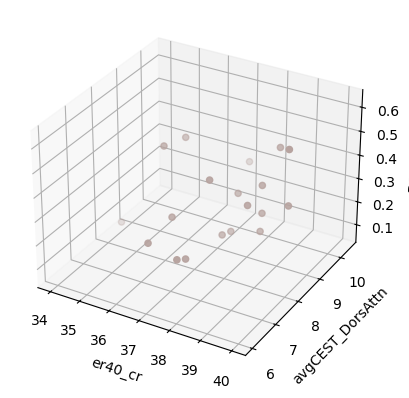

      medf_pc  avgCEST_DorsAttn  DorsAttn
2   88.888889          6.382527  0.258377
3   77.777778          6.035932  0.287490
5   91.666667          6.972563  0.316759
7   69.444444          8.559614  0.063928
10  77.777778          8.223989  0.243422
11  66.666667          8.287902  0.429669
13  69.444444         10.419630  0.278428
14  72.222222          7.080233  0.176538
15  80.555556          7.078968  0.330240
16  86.111111          6.118033  0.309288
17  86.111111          7.992198  0.510831
18  66.666667          8.277535  0.200455
19  91.666667          8.579904  0.335207
24  69.444444          8.066102  0.401307
25  88.888889          7.902069  0.219597
26  75.000000          7.363532  0.494674
27  80.555556          8.043687  0.631075
30  83.333333          8.293079  0.313409
31  86.111111          8.892468  0.473277


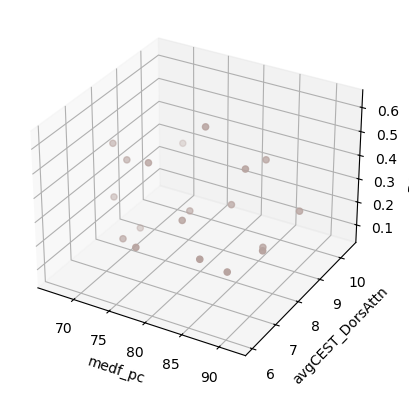

      tap_tot  avgCEST_Vis       Vis
2   104.00000     8.967306  0.396056
3   103.33330     9.610587  0.468854
5    72.33333    12.741945  0.274933
10  105.33330     9.746861  0.738115
11   97.00000    10.589238  0.509295
13  116.33330    12.802977  0.492354
14   92.66666    13.682704  0.967040
15   93.33333     9.176037  0.793801
16  117.00000     9.737379  0.309563
17  103.33330    10.190264  0.354786
18  128.00000     9.714172  0.335023
19  120.00000    10.088696  0.553575
24   96.33333    10.633214  0.342325
25  110.00000    12.498565  0.352182
26  101.66670     7.216132  0.351959
27   92.00000    12.373299  0.484798
30  104.66670    13.772174  0.297944
31  125.66670    12.511567  0.295938


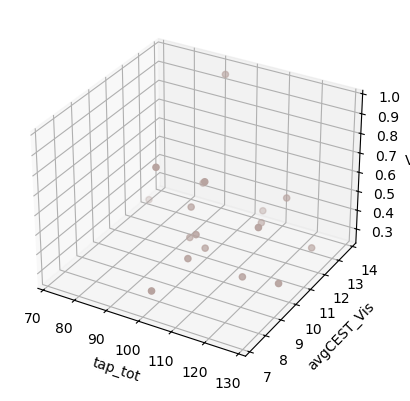

    er40_cr  avgCEST_Vis       Vis
0      39.0    14.297329  0.594154
2      38.0     8.967306  0.396056
3      38.0     9.610587  0.468854
4      39.0     8.387602  0.525277
10     39.0     9.746861  0.738115
11     39.0    10.589238  0.509295
13     37.0    12.802977  0.492354
15     37.0     9.176037  0.793801
16     37.0     9.737379  0.309563
17     36.0    10.190264  0.354786
18     38.0     9.714172  0.335023
19     38.0    10.088696  0.553575
24     40.0    10.633214  0.342325
25     38.0    12.498565  0.352182
26     38.0     7.216132  0.351959
27     40.0    12.373299  0.484798
30     39.0    13.772174  0.297944
31     36.0    12.511567  0.295938


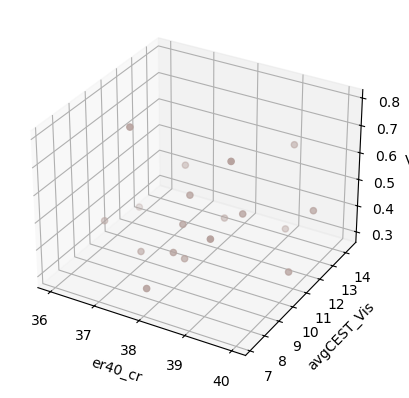

      medf_pc  avgCEST_Vis       Vis
2   88.888889     8.967306  0.396056
3   77.777778     9.610587  0.468854
5   91.666667    12.741945  0.274933
10  77.777778     9.746861  0.738115
11  66.666667    10.589238  0.509295
13  69.444444    12.802977  0.492354
14  72.222222    13.682704  0.967040
15  80.555556     9.176037  0.793801
16  86.111111     9.737379  0.309563
17  86.111111    10.190264  0.354786
18  66.666667     9.714172  0.335023
19  91.666667    10.088696  0.553575
24  69.444444    10.633214  0.342325
25  88.888889    12.498565  0.352182
26  75.000000     7.216132  0.351959
27  80.555556    12.373299  0.484798
30  83.333333    13.772174  0.297944
31  86.111111    12.511567  0.295938


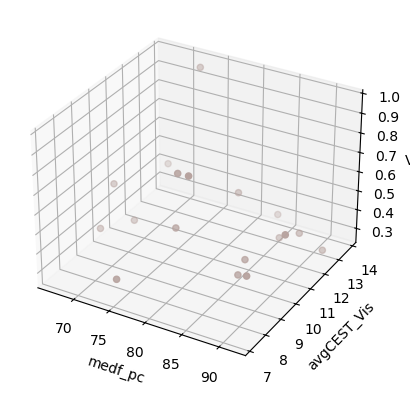

      tap_tot  avgCEST_SalVentAttn  SalVentAttn
2   104.00000             7.277624     0.420864
3   103.33330             7.863291     0.243196
5    72.33333             7.181154     0.302949
7    92.00000             8.124917     0.186044
10  105.33330             7.937581     0.340396
11   97.00000             7.662420     0.424431
13  116.33330             8.939010     0.295722
14   92.66666             7.325671     0.505170
15   93.33333             7.404367     0.378813
16  117.00000             7.365407     0.467500
17  103.33330             7.774126     0.482222
18  128.00000             8.103207     0.437835
19  120.00000             7.989862     0.349883
24   96.33333             7.920916     0.533080
25  110.00000             8.152667     0.318753
26  101.66670             7.594341     0.273180
27   92.00000             8.100647     0.392901
30  104.66670             8.358057     0.159922
31  125.66670             8.547472     0.396681


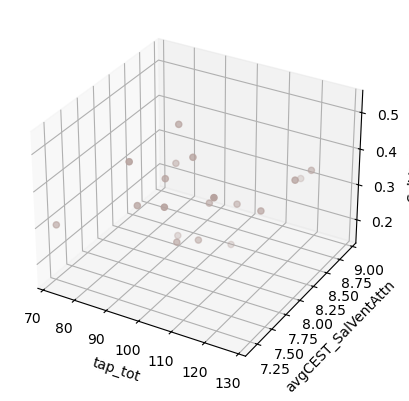

    er40_cr  avgCEST_SalVentAttn  SalVentAttn
0      39.0             8.034846     0.371115
2      38.0             7.277624     0.420864
3      38.0             7.863291     0.243196
4      39.0             8.805663     0.222687
7      34.0             8.124917     0.186044
10     39.0             7.937581     0.340396
11     39.0             7.662420     0.424431
13     37.0             8.939010     0.295722
15     37.0             7.404367     0.378813
16     37.0             7.365407     0.467500
17     36.0             7.774126     0.482222
18     38.0             8.103207     0.437835
19     38.0             7.989862     0.349883
24     40.0             7.920916     0.533080
25     38.0             8.152667     0.318753
26     38.0             7.594341     0.273180
27     40.0             8.100647     0.392901
30     39.0             8.358057     0.159922
31     36.0             8.547472     0.396681


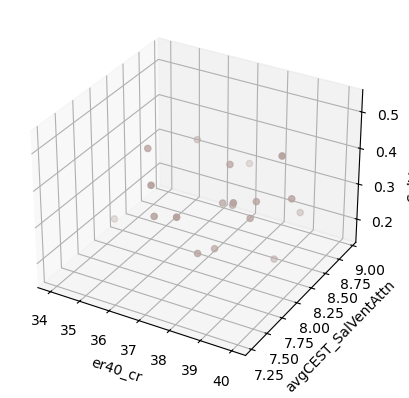

      medf_pc  avgCEST_SalVentAttn  SalVentAttn
2   88.888889             7.277624     0.420864
3   77.777778             7.863291     0.243196
5   91.666667             7.181154     0.302949
7   69.444444             8.124917     0.186044
10  77.777778             7.937581     0.340396
11  66.666667             7.662420     0.424431
13  69.444444             8.939010     0.295722
14  72.222222             7.325671     0.505170
15  80.555556             7.404367     0.378813
16  86.111111             7.365407     0.467500
17  86.111111             7.774126     0.482222
18  66.666667             8.103207     0.437835
19  91.666667             7.989862     0.349883
24  69.444444             7.920916     0.533080
25  88.888889             8.152667     0.318753
26  75.000000             7.594341     0.273180
27  80.555556             8.100647     0.392901
30  83.333333             8.358057     0.159922
31  86.111111             8.547472     0.396681


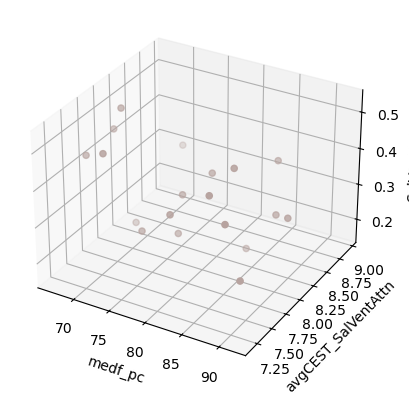

      tap_tot  avgCEST_SomMot    SomMot
3   103.33330        8.048849  0.476986
5    72.33333        6.923363  0.530501
7    92.00000        8.360912  0.207787
10  105.33330        7.416647  0.458101
11   97.00000        7.336883  0.495047
13  116.33330        8.874376  0.438165
14   92.66666        7.077155  0.330849
15   93.33333        7.627305  0.276265
16  117.00000        6.892677  0.389875
17  103.33330        8.036966  0.519093
18  128.00000        8.222816  0.371118
19  120.00000        7.866533  0.616235
24   96.33333        7.681239  0.631874
25  110.00000        7.964384  0.323271
26  101.66670        7.400841  0.457556
27   92.00000        7.430732  0.372234
30  104.66670        8.525817  0.221894
31  125.66670        8.374417  0.397562


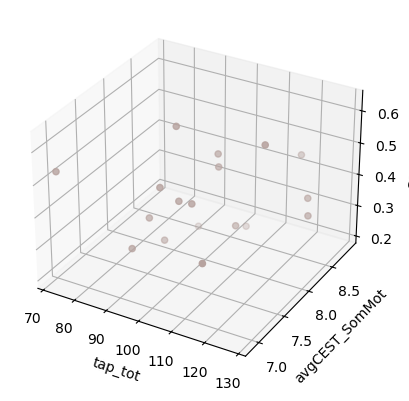

    er40_cr  avgCEST_SomMot    SomMot
0      39.0        7.723693  0.504323
3      38.0        8.048849  0.476986
4      39.0        8.941838  0.517550
7      34.0        8.360912  0.207787
10     39.0        7.416647  0.458101
11     39.0        7.336883  0.495047
13     37.0        8.874376  0.438165
15     37.0        7.627305  0.276265
16     37.0        6.892677  0.389875
17     36.0        8.036966  0.519093
18     38.0        8.222816  0.371118
19     38.0        7.866533  0.616235
24     40.0        7.681239  0.631874
25     38.0        7.964384  0.323271
26     38.0        7.400841  0.457556
27     40.0        7.430732  0.372234
30     39.0        8.525817  0.221894
31     36.0        8.374417  0.397562


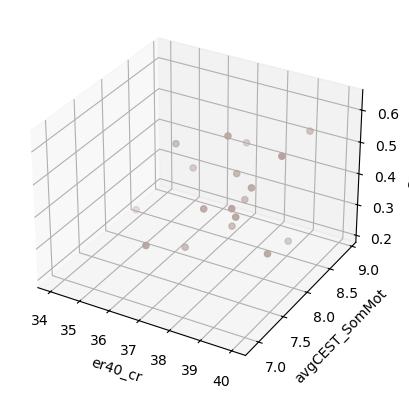

      medf_pc  avgCEST_SomMot    SomMot
3   77.777778        8.048849  0.476986
5   91.666667        6.923363  0.530501
7   69.444444        8.360912  0.207787
10  77.777778        7.416647  0.458101
11  66.666667        7.336883  0.495047
13  69.444444        8.874376  0.438165
14  72.222222        7.077155  0.330849
15  80.555556        7.627305  0.276265
16  86.111111        6.892677  0.389875
17  86.111111        8.036966  0.519093
18  66.666667        8.222816  0.371118
19  91.666667        7.866533  0.616235
24  69.444444        7.681239  0.631874
25  88.888889        7.964384  0.323271
26  75.000000        7.400841  0.457556
27  80.555556        7.430732  0.372234
30  83.333333        8.525817  0.221894
31  86.111111        8.374417  0.397562


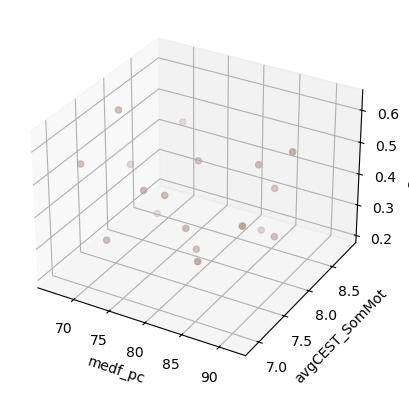

      tap_tot  avgCEST_Limbic    Limbic
2   104.00000       10.076208  0.556081
3   103.33330        5.855585  0.557474
5    72.33333       10.419856  0.355055
7    92.00000        5.411261  0.219353
10  105.33330        7.552845  0.553482
13  116.33330        6.410949  0.470029
15   93.33333        4.421310  0.308839
17  103.33330        6.229536  0.343770
24   96.33333        7.509117  0.488638
26  101.66670        4.831669  0.323012
31  125.66670        6.177131  0.434284


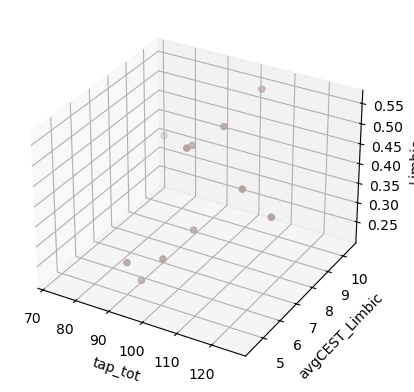

    er40_cr  avgCEST_Limbic    Limbic
2      38.0       10.076208  0.556081
3      38.0        5.855585  0.557474
4      39.0        6.432389  0.625961
7      34.0        5.411261  0.219353
10     39.0        7.552845  0.553482
13     37.0        6.410949  0.470029
15     37.0        4.421310  0.308839
17     36.0        6.229536  0.343770
24     40.0        7.509117  0.488638
26     38.0        4.831669  0.323012
31     36.0        6.177131  0.434284


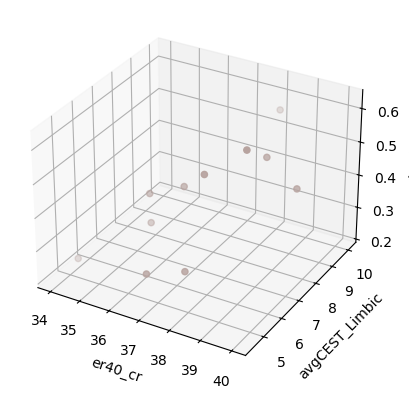

      medf_pc  avgCEST_Limbic    Limbic
2   88.888889       10.076208  0.556081
3   77.777778        5.855585  0.557474
5   91.666667       10.419856  0.355055
7   69.444444        5.411261  0.219353
10  77.777778        7.552845  0.553482
13  69.444444        6.410949  0.470029
15  80.555556        4.421310  0.308839
17  86.111111        6.229536  0.343770
24  69.444444        7.509117  0.488638
26  75.000000        4.831669  0.323012
31  86.111111        6.177131  0.434284


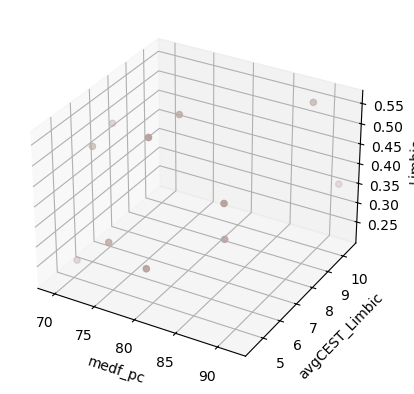

In [145]:
#BBS2

from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

if run_grpanalysis:
    # Curate data 
    value_counts = grp_df['dx_pscat'].value_counts()
    print(value_counts)
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('NC', 'HC')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PROR', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PRO', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('S', 'PSY')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('O', 'Other')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('Unknown', 'Other')
    grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('MDD', 'Other')
    value_counts = grp_df['dx_pscat'].value_counts()
    print(value_counts)
    
    colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
        'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 
    
    anova_tables = []
    # Create a scatter plot with a multiple linear regression 
    for network in networks:
        cestcol = "avgCEST_" + network
        # Create a linear regression model for fcon
       # color = colors.loc[colors['Network'] == network, 'Color'].values[0]
       # sns.set_palette(color)

        # Create CNB correlation plot for each network fcon and cest 
        for CNB_score in CNB_scores:
         #   graph_df = grp_df[grp_df['dx_pscat'] != 'Other']
            graph_df = grp_df
            graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
            graph_df = graph_df[[CNB_score, cestcol, network]]
            # Define x values and target variable
            X = graph_df[[cestcol, network]]
            Y = graph_df[CNB_score]
            
            ##################################
            # Define formula and model
            #formula = f'{CNB_score} ~ {cestcol} + {network}'
            #model = smf.ols(formula=formula, data=graph_df).fit()
            #print(network + CNB_score)
            #print(model.summary())
            print(graph_df)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection = '3d')
            ax.scatter(graph_df[CNB_score], graph_df[cestcol], graph_df[network])
            ax.set_xlabel(CNB_score)
            ax.set_ylabel(cestcol)
            ax.set_zlabel(network)
            plt.show()
            
            
